# Drilldown Solutions - Comprehensive Business Analytics Dashboard

## Executive Summary
This notebook provides an in-depth analysis of Drilldown Solutions' business data, including sales performance, customer insights, product analytics, and financial metrics. The analysis covers companies, contacts, deals, invoices, and products to provide actionable business intelligence.

## Table of Contents
1. [Data Loading and Initial Setup](#data-loading)
2. [Data Quality Assessment](#data-quality)
3. [Company and Customer Analysis](#company-analysis)
4. [Sales Performance Analysis](#sales-analysis)
5. [Product Performance Analysis](#product-analysis)
6. [Financial Analysis](#financial-analysis)
7. [Sales Rep Performance](#sales-rep-analysis)
8. [Geographic Analysis](#geographic-analysis)
9. [Time Series Analysis](#time-series)
10. [Key Insights and Recommendations](#insights)


## 1. Data Loading and Initial Setup {#data-loading}


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.figure_factory as ff

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Libraries imported successfully!
Analysis started at: 2025-09-16 16:04:20


In [2]:
# Load all datasets
data_path = '../dbt/data/'

# Load main datasets
companies = pd.read_csv(f'{data_path}companies.csv')
contacts = pd.read_csv(f'{data_path}contacts.csv')
deals = pd.read_csv(f'{data_path}deals.csv')
invoices = pd.read_csv(f'{data_path}invoices.csv')
invoice_lines = pd.read_csv(f'{data_path}invoice_lines.csv')
products = pd.read_csv(f'{data_path}products.csv')

# Display basic information about each dataset
datasets = {
    'Companies': companies,
    'Contacts': contacts,
    'Deals': deals,
    'Invoices': invoices,
    'Invoice Lines': invoice_lines,
    'Products': products
}

print("=== DATASET OVERVIEW ===")
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
    
print(f"\nTotal records across all datasets: {sum(df.shape[0] for df in datasets.values())}")


=== DATASET OVERVIEW ===

Companies:
  Shape: (100, 8)
  Columns: ['company_id', 'company_name', 'industry', 'annual_revenue', 'employee_count', 'country', 'created_date', 'owner_id']
  Memory usage: 26.72 KB

Contacts:
  Shape: (100, 8)
  Columns: ['contact_id', 'company_id', 'first_name', 'last_name', 'email', 'job_title', 'lead_source', 'created_date']
  Memory usage: 37.00 KB

Deals:
  Shape: (94, 8)
  Columns: ['deal_id', 'deal_name', 'company_id', 'amount', 'deal_stage', 'close_date', 'created_date', 'owner_id']
  Memory usage: 26.52 KB

Invoices:
  Shape: (67, 8)
  Columns: ['invoice_id', 'company_id', 'deal_id', 'invoice_date', 'due_date', 'total_amount', 'status', 'paid_date']
  Memory usage: 16.96 KB

Invoice Lines:
  Shape: (134, 8)
  Columns: ['invoice_line_id', 'invoice_id', 'product_id', 'quantity', 'unit_price', 'line_total', 'Unnamed: 6', 'Unnamed: 7']
  Memory usage: 14.16 KB

Products:
  Shape: (8, 5)
  Columns: ['product_id', 'product_name', 'description', 'unit_pric

In [3]:
# Data preprocessing and type conversion
def preprocess_data():
    """Preprocess all datasets with proper data types and date conversions"""
    
    # Convert date columns
    date_columns = {
        'companies': ['created_date'],
        'contacts': ['created_date'],
        'deals': ['close_date', 'created_date'],
        'invoices': ['invoice_date', 'due_date', 'paid_date']
    }
    
    for dataset_name, cols in date_columns.items():
        df = globals()[dataset_name]
        for col in cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Convert numeric columns
    companies['annual_revenue'] = pd.to_numeric(companies['annual_revenue'], errors='coerce')
    companies['employee_count'] = pd.to_numeric(companies['employee_count'], errors='coerce')
    deals['amount'] = pd.to_numeric(deals['amount'], errors='coerce')
    invoices['total_amount'] = pd.to_numeric(invoices['total_amount'], errors='coerce')
    invoice_lines['quantity'] = pd.to_numeric(invoice_lines['quantity'], errors='coerce')
    invoice_lines['unit_price'] = pd.to_numeric(invoice_lines['unit_price'], errors='coerce')
    invoice_lines['line_total'] = pd.to_numeric(invoice_lines['line_total'], errors='coerce')
    products['unit_price'] = pd.to_numeric(products['unit_price'], errors='coerce')
    
    print("Data preprocessing completed successfully!")

preprocess_data()

# Display sample data from each dataset
print("\n=== SAMPLE DATA ===")
for name, df in datasets.items():
    print(f"\n{name} - First 3 rows:")
    print(df.head(3))
    print("-" * 50)


Data preprocessing completed successfully!

=== SAMPLE DATA ===

Companies - First 3 rows:
   company_id           company_name       industry  annual_revenue  \
0           1     Innovate Solutions       Software         5500000   
1           2  Quantum Manufacturing  Manufacturing        12000000   
2           3      Apex Retail Group         Retail         8200000   

   employee_count      country created_date  owner_id  
0             250  Netherlands   2023-01-15       101  
1             800      Germany   2023-02-20       102  
2             450          USA   2023-03-10       101  
--------------------------------------------------

Contacts - First 3 rows:
   contact_id  company_id first_name last_name  \
0         201           1       Anna   Devries   
1         202           1        Ben    Jansen   
2         203           2      Klaus   Schmidt   

                                   email            job_title     lead_source  \
0     anna.devries@innovatesolutions.com 

## 2. Data Quality Assessment {#data-quality}


=== DATA QUALITY ASSESSMENT ===

Companies:
  Total Rows: 100
  Total Columns: 8
  Duplicate Rows: 0
  Memory Usage: 21.74 KB
  Missing Values: None

Contacts:
  Total Rows: 100
  Total Columns: 8
  Duplicate Rows: 0
  Memory Usage: 32.02 KB
  Missing Values: None

Deals:
  Total Rows: 94
  Total Columns: 8
  Duplicate Rows: 0
  Memory Usage: 17.16 KB
  Missing Values: None

Invoices:
  Total Rows: 67
  Total Columns: 8
  Duplicate Rows: 0
  Memory Usage: 7.29 KB
  Missing Values:
    paid_date: 19.4%

Invoice Lines:
  Total Rows: 134
  Total Columns: 8
  Duplicate Rows: 0
  Memory Usage: 14.16 KB
  Missing Values:
    line_total: 0.7%
    Unnamed: 6: 98.5%
    Unnamed: 7: 98.5%

Products:
  Total Rows: 8
  Total Columns: 5
  Duplicate Rows: 0
  Memory Usage: 2.05 KB
  Missing Values: None


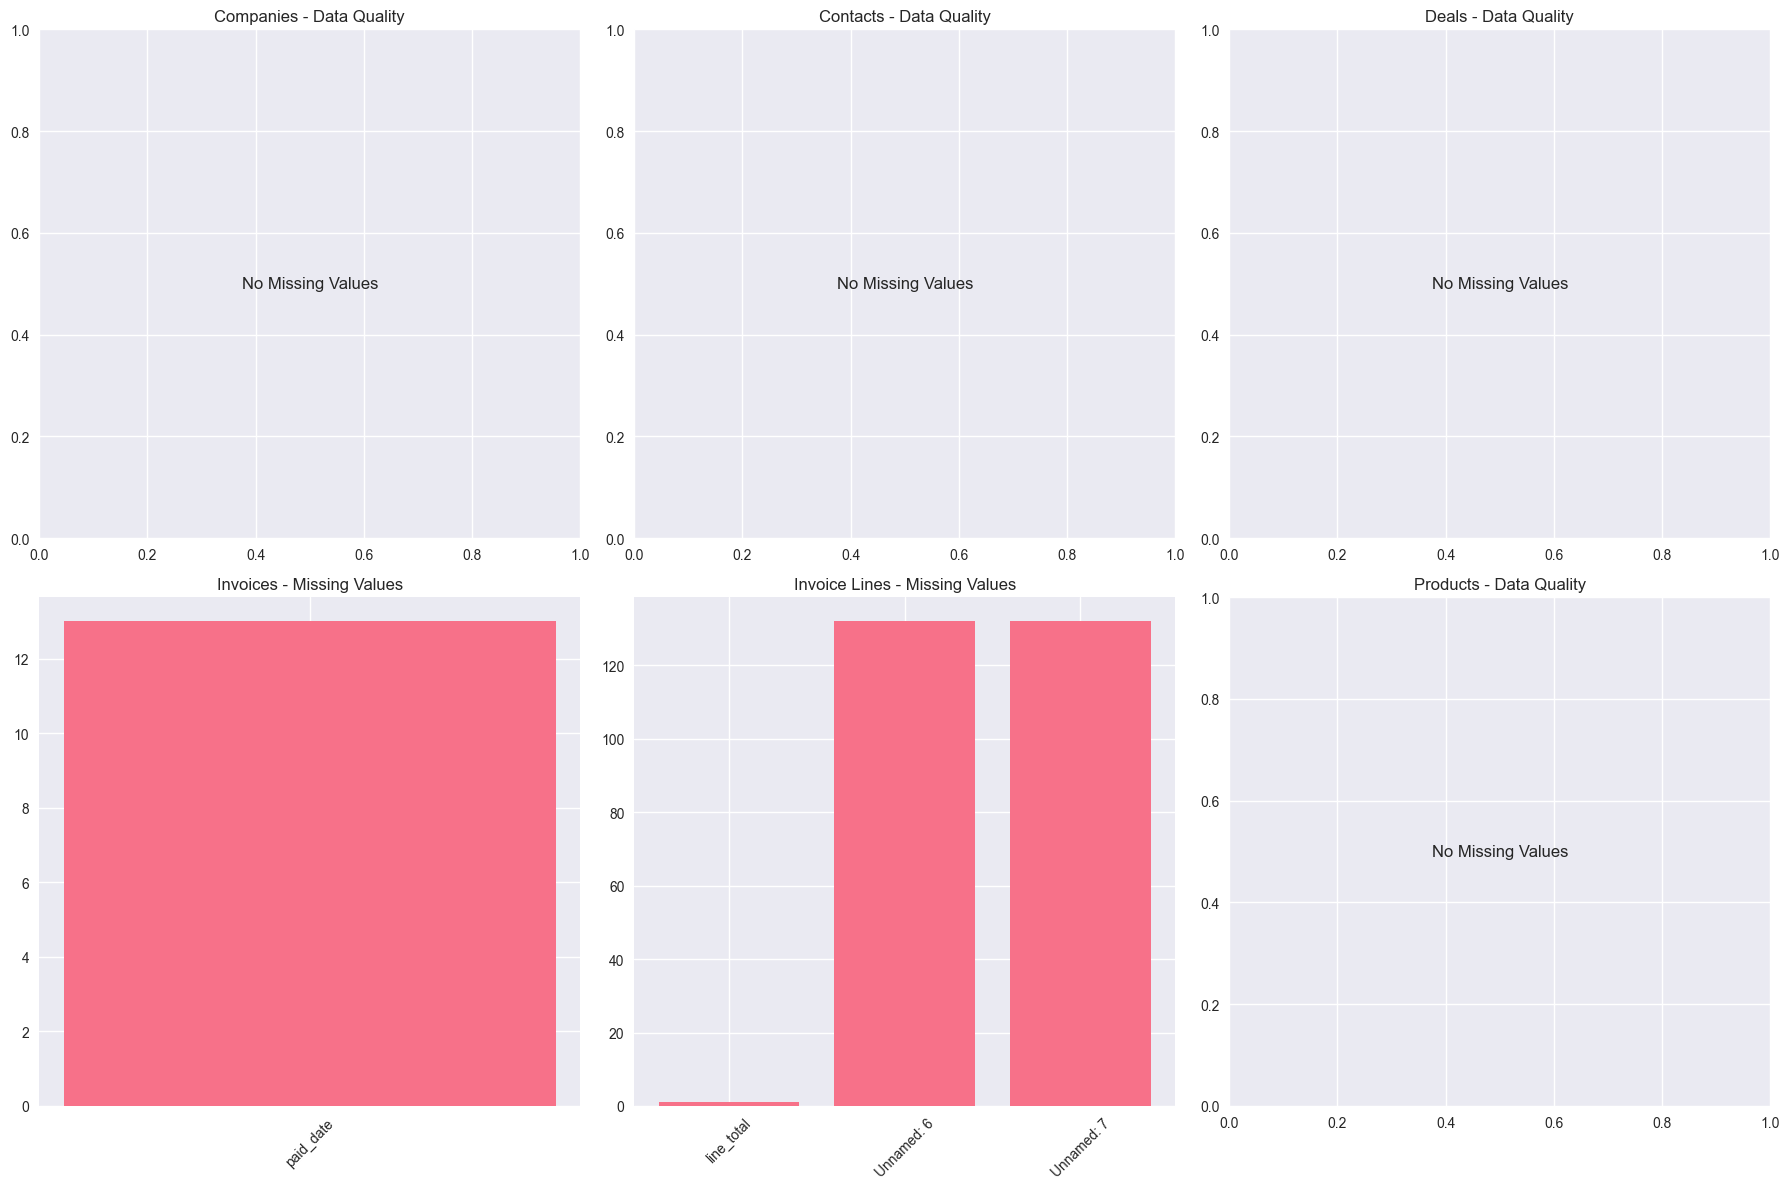

In [4]:
# Comprehensive data quality assessment
def assess_data_quality():
    """Perform comprehensive data quality assessment"""
    
    quality_report = {}
    
    for name, df in datasets.items():
        report = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'missing_values': df.isnull().sum().to_dict(),
            'duplicate_rows': df.duplicated().sum(),
            'data_types': df.dtypes.to_dict(),
            'memory_usage': df.memory_usage(deep=True).sum() / 1024
        }
        
        # Calculate missing value percentages
        missing_pct = (df.isnull().sum() / len(df) * 100).to_dict()
        report['missing_percentages'] = missing_pct
        
        quality_report[name] = report
    
    return quality_report

quality_report = assess_data_quality()

# Display data quality summary
print("=== DATA QUALITY ASSESSMENT ===")
for dataset_name, report in quality_report.items():
    print(f"\n{dataset_name}:")
    print(f"  Total Rows: {report['total_rows']:,}")
    print(f"  Total Columns: {report['total_columns']}")
    print(f"  Duplicate Rows: {report['duplicate_rows']}")
    print(f"  Memory Usage: {report['memory_usage']:.2f} KB")
    
    # Show columns with missing values
    missing_cols = {k: v for k, v in report['missing_percentages'].items() if v > 0}
    if missing_cols:
        print(f"  Missing Values:")
        for col, pct in missing_cols.items():
            print(f"    {col}: {pct:.1f}%")
    else:
        print(f"  Missing Values: None")

# Create data quality visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (name, df) in enumerate(datasets.items()):
    if i < len(axes):
        # Missing values heatmap
        missing_data = df.isnull().sum()
        if missing_data.sum() > 0:
            missing_data = missing_data[missing_data > 0]
            axes[i].bar(missing_data.index, missing_data.values)
            axes[i].set_title(f'{name} - Missing Values')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'{name} - Data Quality')

plt.tight_layout()
plt.show()


## 3. Company and Customer Analysis {#company-analysis}



In [5]:
# Company analysis
print("=== COMPANY ANALYSIS ===")

# Basic company statistics
print(f"Total Companies: {len(companies):,}")
print(f"Industries: {companies['industry'].nunique()}")
print(f"Countries: {companies['country'].nunique()}")
print(f"Date Range: {companies['created_date'].min().strftime('%Y-%m-%d')} to {companies['created_date'].max().strftime('%Y-%m-%d')}")

# Industry distribution
industry_stats = companies.groupby('industry').agg({
    'company_id': 'count',
    'annual_revenue': ['mean', 'median', 'sum'],
    'employee_count': ['mean', 'median']
}).round(2)

industry_stats.columns = ['Company_Count', 'Avg_Revenue', 'Median_Revenue', 'Total_Revenue', 'Avg_Employees', 'Median_Employees']
industry_stats = industry_stats.sort_values('Total_Revenue', ascending=False)

print("\n=== INDUSTRY BREAKDOWN ===")
print(industry_stats)

# Country distribution
country_stats = companies.groupby('country').agg({
    'company_id': 'count',
    'annual_revenue': ['mean', 'sum'],
    'employee_count': 'mean'
}).round(2)

country_stats.columns = ['Company_Count', 'Avg_Revenue', 'Total_Revenue', 'Avg_Employees']
country_stats = country_stats.sort_values('Total_Revenue', ascending=False)

print("\n=== COUNTRY BREAKDOWN ===")
print(country_stats)


=== COMPANY ANALYSIS ===
Total Companies: 100
Industries: 90
Countries: 6
Date Range: 2023-01-15 to 2024-05-15

=== INDUSTRY BREAKDOWN ===
                         Company_Count   Avg_Revenue  Median_Revenue  \
industry                                                               
Aviation                             1  2.500000e+08     250000000.0   
Aerospace                            2  9.750000e+07      97500000.0   
Oil & Gas                            1  1.800000e+08     180000000.0   
Banking                              1  1.500000e+08     150000000.0   
Energy                               2  6.700000e+07      67000000.0   
Pharmaceuticals                      1  1.200000e+08     120000000.0   
Defense                              1  9.500000e+07      95000000.0   
Semiconductors                       1  9.500000e+07      95000000.0   
Biotechnology                        1  9.000000e+07      90000000.0   
Mining                               1  7.500000e+07      75000000.0 

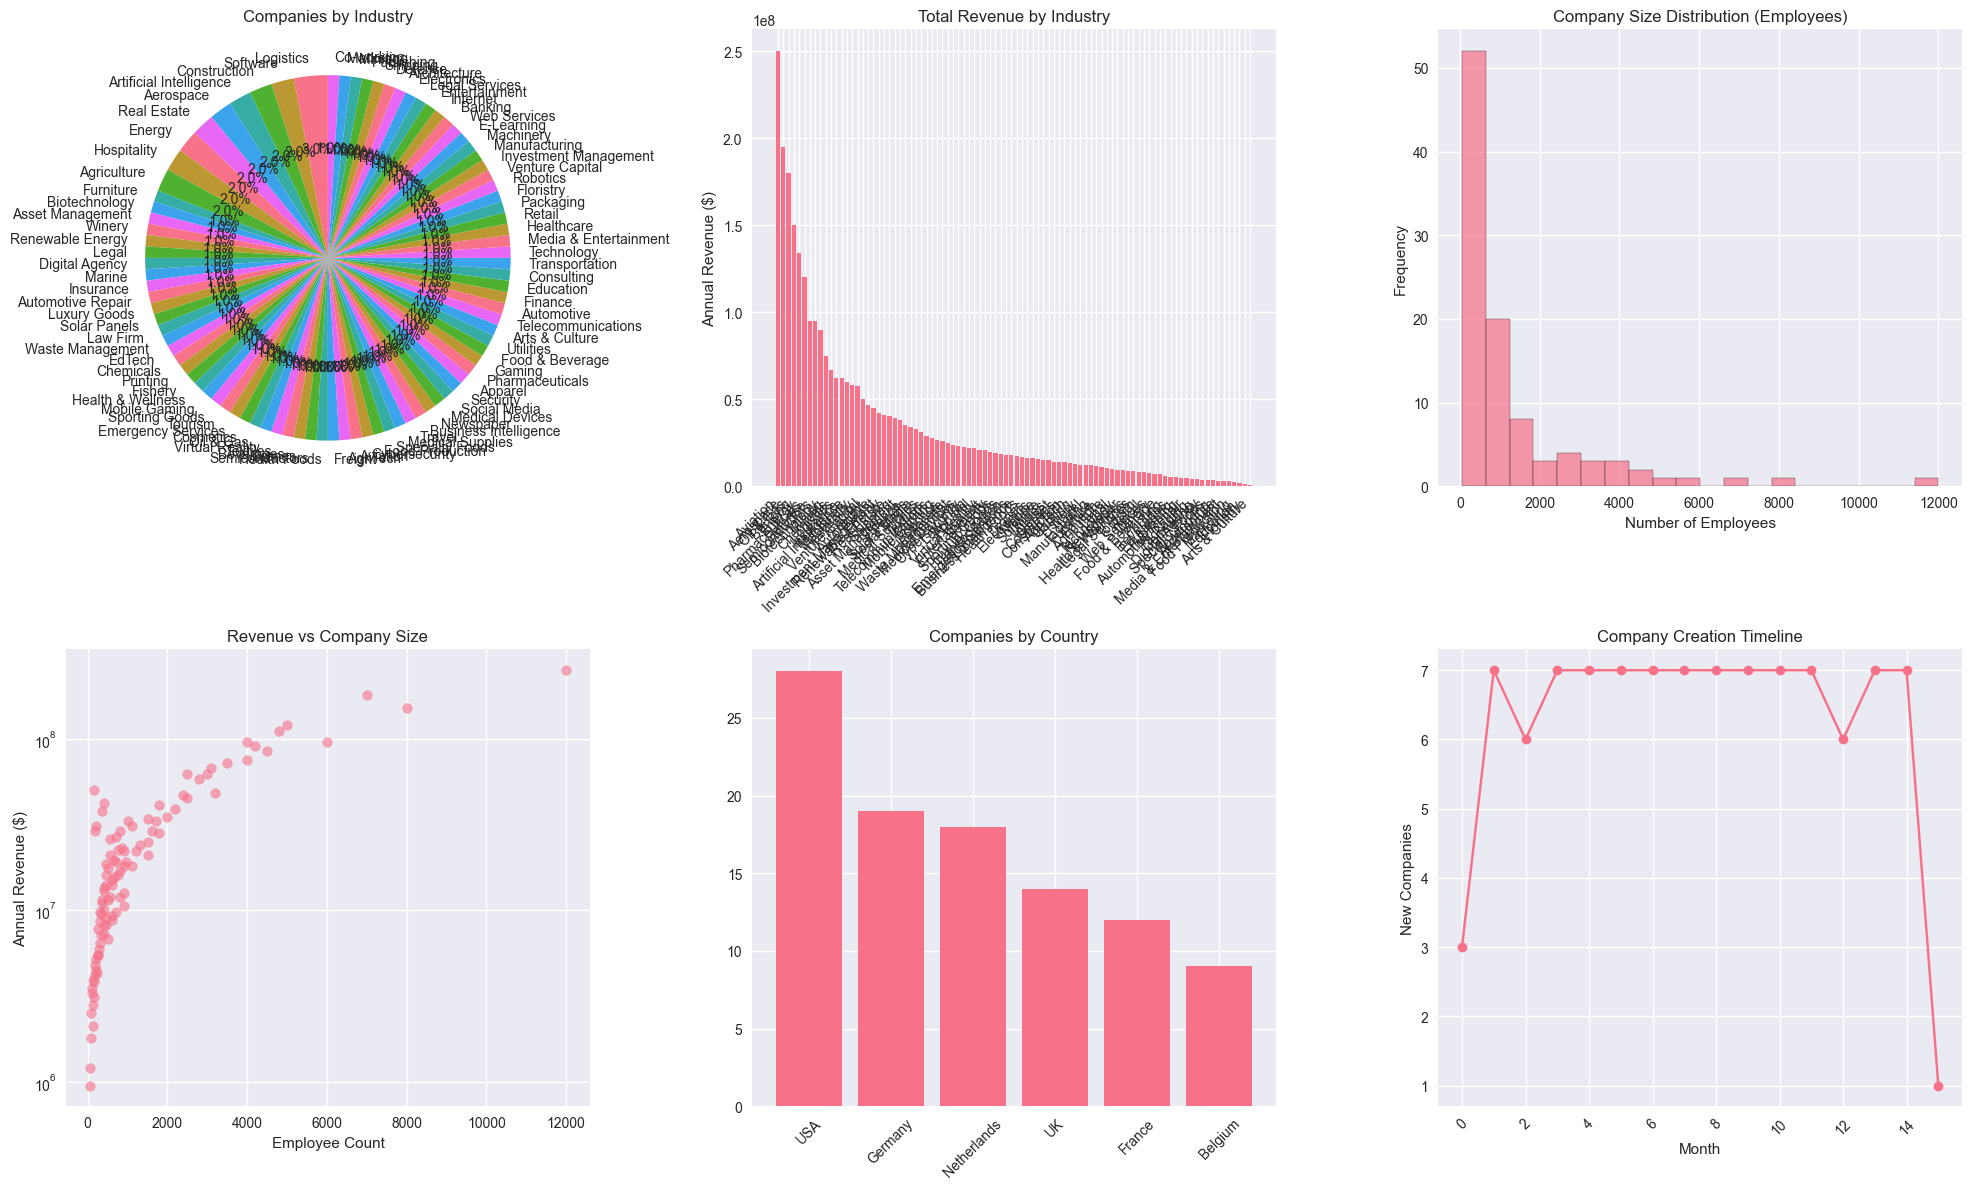

In [6]:
# Company analysis visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Industry distribution by company count
industry_counts = companies['industry'].value_counts()
axes[0, 0].pie(industry_counts.values, labels=industry_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Companies by Industry')

# 2. Revenue distribution by industry
industry_revenue = companies.groupby('industry')['annual_revenue'].sum().sort_values(ascending=False)
axes[0, 1].bar(range(len(industry_revenue)), industry_revenue.values)
axes[0, 1].set_xticks(range(len(industry_revenue)))
axes[0, 1].set_xticklabels(industry_revenue.index, rotation=45, ha='right')
axes[0, 1].set_title('Total Revenue by Industry')
axes[0, 1].set_ylabel('Annual Revenue ($)')

# 3. Company size distribution
axes[0, 2].hist(companies['employee_count'].dropna(), bins=20, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Company Size Distribution (Employees)')
axes[0, 2].set_xlabel('Number of Employees')
axes[0, 2].set_ylabel('Frequency')

# 4. Revenue vs Employee count scatter
axes[1, 0].scatter(companies['employee_count'], companies['annual_revenue'], alpha=0.6)
axes[1, 0].set_xlabel('Employee Count')
axes[1, 0].set_ylabel('Annual Revenue ($)')
axes[1, 0].set_title('Revenue vs Company Size')
axes[1, 0].set_yscale('log')

# 5. Geographic distribution
country_counts = companies['country'].value_counts()
axes[1, 1].bar(country_counts.index, country_counts.values)
axes[1, 1].set_title('Companies by Country')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Company creation timeline
companies['year_month'] = companies['created_date'].dt.to_period('M')
monthly_creation = companies.groupby('year_month').size()
axes[1, 2].plot(range(len(monthly_creation)), monthly_creation.values, marker='o')
axes[1, 2].set_title('Company Creation Timeline')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('New Companies')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



=== CONTACT ANALYSIS ===
Total Contacts: 100
Unique Companies with Contacts: 98
Lead Sources: 5

=== LEAD SOURCE BREAKDOWN ===
                Contact_Count  Unique_Companies
lead_source                                    
Webinar                    24                24
Referral                   23                23
Organic Search             22                22
Trade Show                 20                20
Cold Call                  11                11

=== TOP 10 JOB TITLES ===
job_title
Community Manager       2
CEO                     2
Fleet Manager           2
Senior Partner          2
Master Watchmaker       1
Machine Learning Eng    1
Project Engineer        1
Associate Attorney      1
UX Designer             1
Naval Architect         1
Name: count, dtype: int64


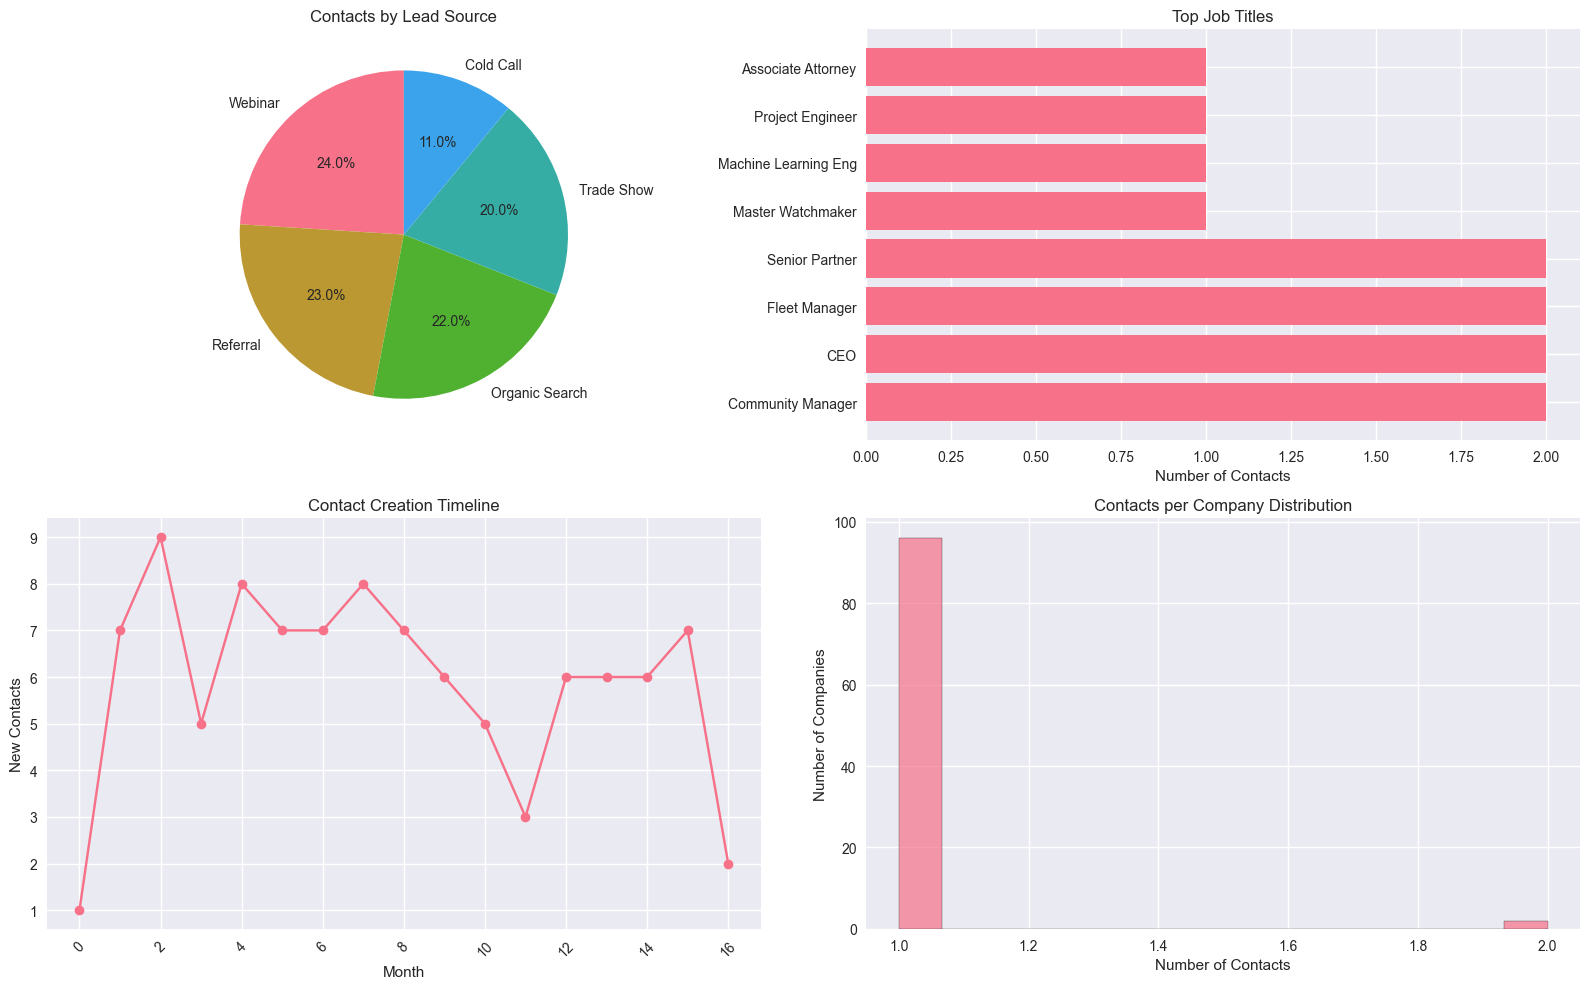

In [7]:
# Contact analysis
print("\n=== CONTACT ANALYSIS ===")

# Basic contact statistics
print(f"Total Contacts: {len(contacts):,}")
print(f"Unique Companies with Contacts: {contacts['company_id'].nunique()}")
print(f"Lead Sources: {contacts['lead_source'].nunique()}")

# Lead source analysis
lead_source_stats = contacts.groupby('lead_source').agg({
    'contact_id': 'count',
    'company_id': 'nunique'
}).rename(columns={'contact_id': 'Contact_Count', 'company_id': 'Unique_Companies'})

print("\n=== LEAD SOURCE BREAKDOWN ===")
print(lead_source_stats.sort_values('Contact_Count', ascending=False))

# Job title analysis
job_title_stats = contacts['job_title'].value_counts().head(10)
print("\n=== TOP 10 JOB TITLES ===")
print(job_title_stats)

# Contact creation timeline
contacts['year_month'] = contacts['created_date'].dt.to_period('M')
monthly_contacts = contacts.groupby('year_month').size()

# Visualize contact analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Lead source distribution
lead_source_counts = contacts['lead_source'].value_counts()
axes[0, 0].pie(lead_source_counts.values, labels=lead_source_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Contacts by Lead Source')

# Job title distribution
job_title_counts = contacts['job_title'].value_counts().head(8)
axes[0, 1].barh(range(len(job_title_counts)), job_title_counts.values)
axes[0, 1].set_yticks(range(len(job_title_counts)))
axes[0, 1].set_yticklabels(job_title_counts.index)
axes[0, 1].set_title('Top Job Titles')
axes[0, 1].set_xlabel('Number of Contacts')

# Contact creation timeline
axes[1, 0].plot(range(len(monthly_contacts)), monthly_contacts.values, marker='o')
axes[1, 0].set_title('Contact Creation Timeline')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('New Contacts')
axes[1, 0].tick_params(axis='x', rotation=45)

# Contacts per company
contacts_per_company = contacts.groupby('company_id').size()
axes[1, 1].hist(contacts_per_company, bins=15, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Contacts per Company Distribution')
axes[1, 1].set_xlabel('Number of Contacts')
axes[1, 1].set_ylabel('Number of Companies')

plt.tight_layout()
plt.show()


## 4. Sales Performance Analysis {#sales-analysis}


In [8]:
# Sales performance analysis
print("=== SALES PERFORMANCE ANALYSIS ===")

# Basic deal statistics
print(f"Total Deals: {len(deals):,}")
print(f"Total Deal Value: ${deals['amount'].sum():,.2f}")
print(f"Average Deal Size: ${deals['amount'].mean():,.2f}")
print(f"Median Deal Size: ${deals['amount'].median():,.2f}")

# Deal stage analysis
deal_stage_stats = deals.groupby('deal_stage').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean', 'median']
}).round(2)

deal_stage_stats.columns = ['Deal_Count', 'Total_Value', 'Avg_Value', 'Median_Value']
deal_stage_stats = deal_stage_stats.sort_values('Total_Value', ascending=False)

print("\n=== DEAL STAGE BREAKDOWN ===")
print(deal_stage_stats)

# Sales rep performance
sales_rep_stats = deals.groupby('owner_id').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum()
}).round(2)

sales_rep_stats.columns = ['Total_Deals', 'Total_Value', 'Avg_Deal_Size', 'Won_Deals']
sales_rep_stats['Win_Rate'] = (sales_rep_stats['Won_Deals'] / sales_rep_stats['Total_Deals'] * 100).round(2)
sales_rep_stats = sales_rep_stats.sort_values('Total_Value', ascending=False)

print("\n=== SALES REP PERFORMANCE ===")
print(sales_rep_stats)

# Deal size distribution
print(f"\n=== DEAL SIZE DISTRIBUTION ===")
print(f"Min Deal: ${deals['amount'].min():,.2f}")
print(f"25th Percentile: ${deals['amount'].quantile(0.25):,.2f}")
print(f"75th Percentile: ${deals['amount'].quantile(0.75):,.2f}")
print(f"Max Deal: ${deals['amount'].max():,.2f}")
print(f"Standard Deviation: ${deals['amount'].std():,.2f}")


=== SALES PERFORMANCE ANALYSIS ===
Total Deals: 94
Total Deal Value: $6,125,000.00
Average Deal Size: $65,159.57
Median Deal Size: $37,500.00

=== DEAL STAGE BREAKDOWN ===
               Deal_Count  Total_Value  Avg_Value  Median_Value
deal_stage                                                     
Closed Won             66      4535500   68719.70       41500.0
Negotiation             7       704000  100571.43       51000.0
Closed Lost            13       615500   47346.15       26000.0
Proposal Sent           7       225000   32142.86       28000.0
Qualification           1        45000   45000.00       45000.0

=== SALES REP PERFORMANCE ===
          Total_Deals  Total_Value  Avg_Deal_Size  Won_Deals  Win_Rate
owner_id                                                              
103                26      2743000      105500.00         17     65.38
101                27      1301500       48203.70         18     66.67
102                19      1207000       63526.32         16     

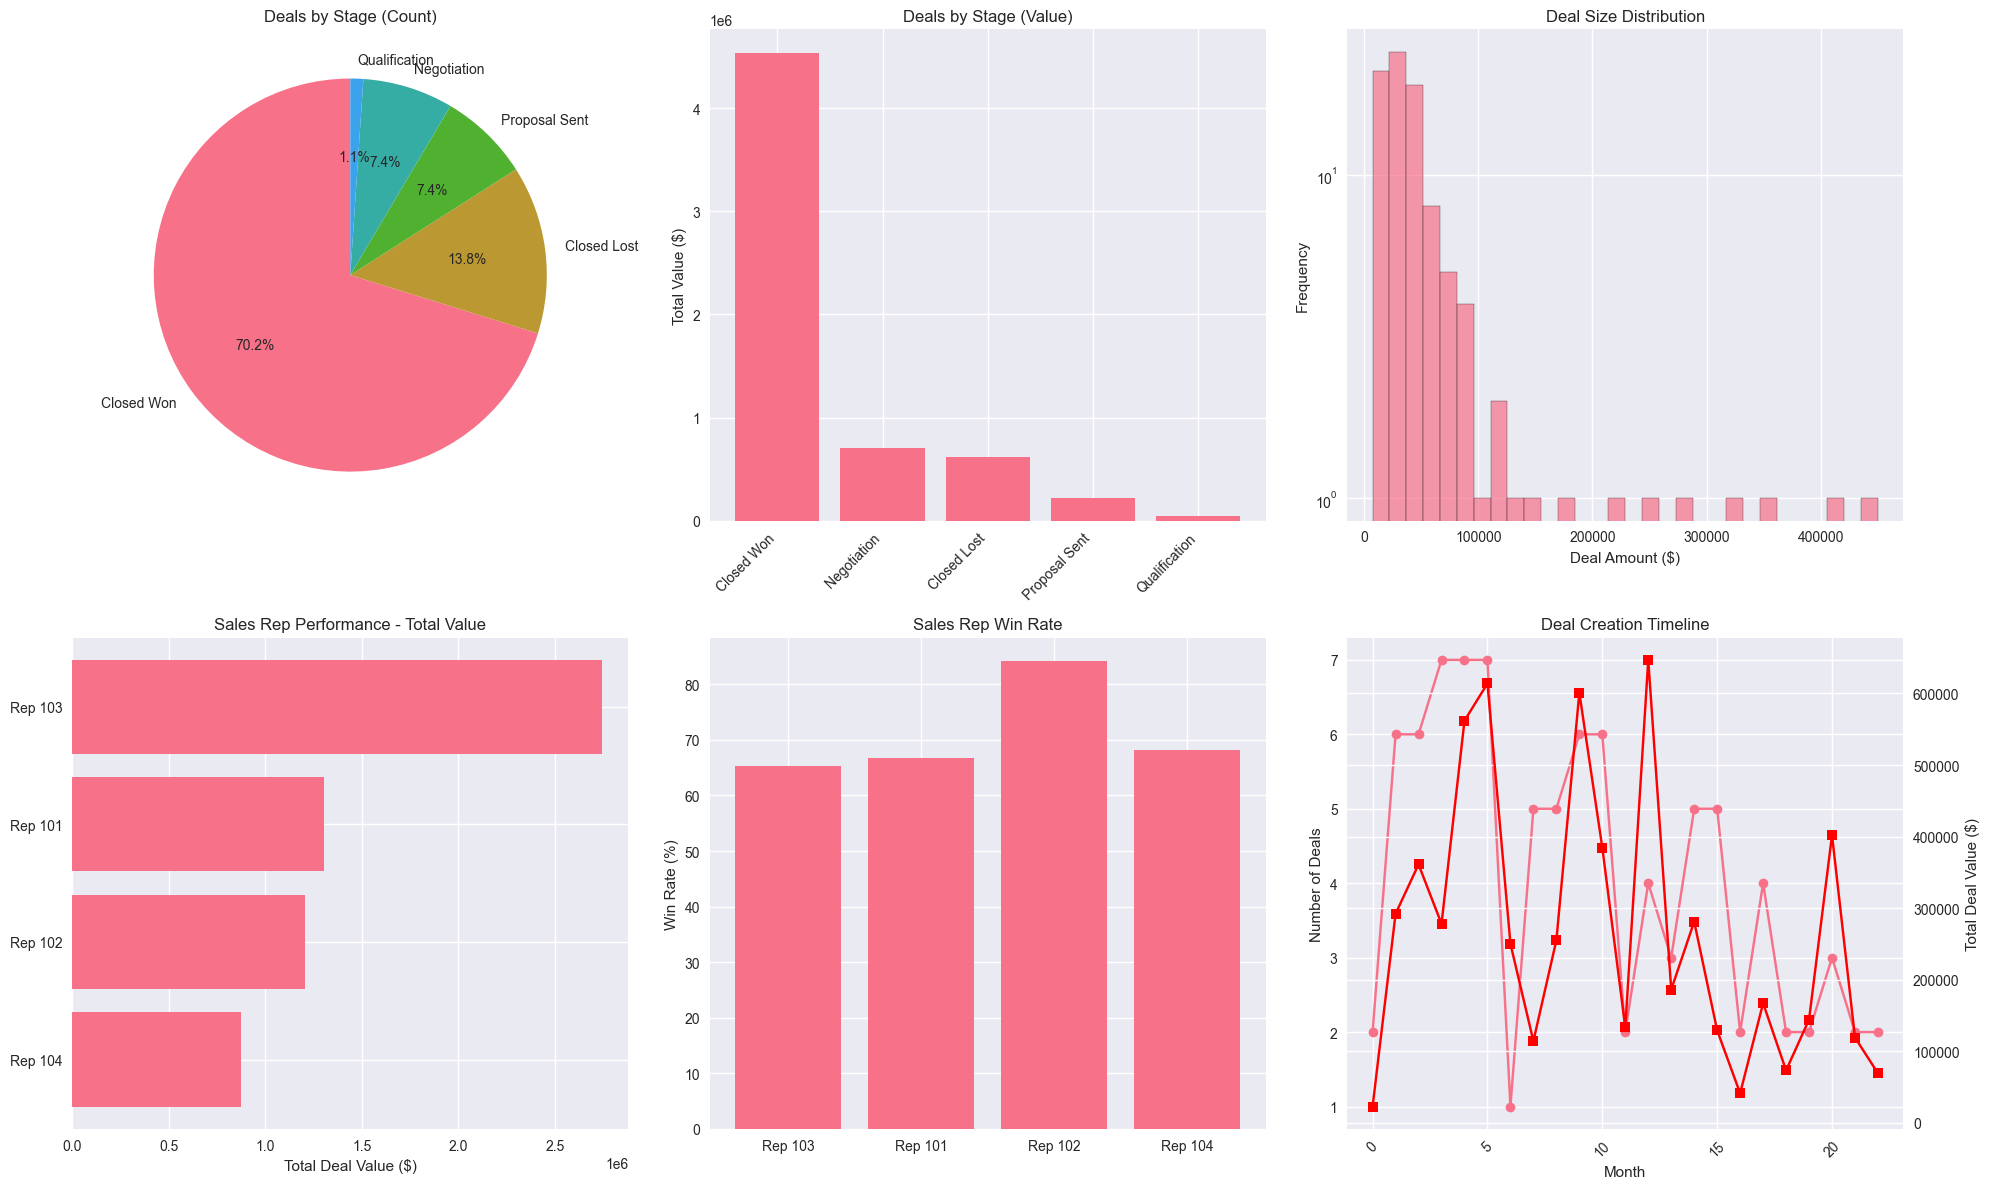

In [9]:
# Sales performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Deal stage distribution by count
deal_stage_counts = deals['deal_stage'].value_counts()
axes[0, 0].pie(deal_stage_counts.values, labels=deal_stage_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Deals by Stage (Count)')

# 2. Deal stage distribution by value
deal_stage_value = deals.groupby('deal_stage')['amount'].sum().sort_values(ascending=False)
axes[0, 1].bar(range(len(deal_stage_value)), deal_stage_value.values)
axes[0, 1].set_xticks(range(len(deal_stage_value)))
axes[0, 1].set_xticklabels(deal_stage_value.index, rotation=45, ha='right')
axes[0, 1].set_title('Deals by Stage (Value)')
axes[0, 1].set_ylabel('Total Value ($)')

# 3. Deal size distribution
axes[0, 2].hist(deals['amount'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Deal Size Distribution')
axes[0, 2].set_xlabel('Deal Amount ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_yscale('log')

# 4. Sales rep performance - total value
sales_rep_value = sales_rep_stats.sort_values('Total_Value', ascending=True)
axes[1, 0].barh(range(len(sales_rep_value)), sales_rep_value['Total_Value'])
axes[1, 0].set_yticks(range(len(sales_rep_value)))
axes[1, 0].set_yticklabels([f'Rep {idx}' for idx in sales_rep_value.index])
axes[1, 0].set_title('Sales Rep Performance - Total Value')
axes[1, 0].set_xlabel('Total Deal Value ($)')

# 5. Sales rep win rate
axes[1, 1].bar(range(len(sales_rep_stats)), sales_rep_stats['Win_Rate'])
axes[1, 1].set_xticks(range(len(sales_rep_stats)))
axes[1, 1].set_xticklabels([f'Rep {idx}' for idx in sales_rep_stats.index])
axes[1, 1].set_title('Sales Rep Win Rate')
axes[1, 1].set_ylabel('Win Rate (%)')

# 6. Deal creation timeline
deals['year_month'] = deals['created_date'].dt.to_period('M')
monthly_deals = deals.groupby('year_month').agg({
    'deal_id': 'count',
    'amount': 'sum'
})
axes[1, 2].plot(range(len(monthly_deals)), monthly_deals['deal_id'], marker='o', label='Deal Count')
ax2 = axes[1, 2].twinx()
ax2.plot(range(len(monthly_deals)), monthly_deals['amount'], marker='s', color='red', label='Deal Value')
axes[1, 2].set_title('Deal Creation Timeline')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Number of Deals')
ax2.set_ylabel('Total Deal Value ($)')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 5. Product Performance Analysis {#product-analysis}


In [10]:
# Product performance analysis
print("=== PRODUCT PERFORMANCE ANALYSIS ===")

# Merge invoice lines with products to get product performance
product_performance = invoice_lines.merge(products, on='product_id', how='left')

# Basic product statistics
print(f"Total Products: {len(products):,}")
print(f"Product Categories: {products['category'].nunique()}")

# Product category analysis
category_stats = products.groupby('category').agg({
    'product_id': 'count',
    'unit_price': ['mean', 'min', 'max']
}).round(2)

category_stats.columns = ['Product_Count', 'Avg_Price', 'Min_Price', 'Max_Price']
print("\n=== PRODUCT CATEGORY BREAKDOWN ===")
print(category_stats)

# Product sales performance
product_sales = product_performance.groupby(['product_id', 'product_name', 'category']).agg({
    'quantity': 'sum',
    'line_total': 'sum',
    'invoice_id': 'nunique'
}).round(2)

product_sales.columns = ['Total_Quantity', 'Total_Revenue', 'Invoice_Count']
product_sales = product_sales.sort_values('Total_Revenue', ascending=False)

print("\n=== TOP 10 PRODUCTS BY REVENUE ===")
print(product_sales.head(10))

# Product category performance
category_performance = product_performance.groupby('category').agg({
    'quantity': 'sum',
    'line_total': 'sum',
    'invoice_id': 'nunique'
}).round(2)

category_performance.columns = ['Total_Quantity', 'Total_Revenue', 'Invoice_Count']
category_performance = category_performance.sort_values('Total_Revenue', ascending=False)

print("\n=== PRODUCT CATEGORY PERFORMANCE ===")
print(category_performance)


=== PRODUCT PERFORMANCE ANALYSIS ===
Total Products: 8
Product Categories: 5

=== PRODUCT CATEGORY BREAKDOWN ===
                       Product_Count  Avg_Price  Min_Price  Max_Price
category                                                             
API Services                       2      850.0        500       1200
Consulting Services                1     5000.0       5000       5000
Software License                   2     2000.0       1500       2500
Software Subscription              1     4000.0       4000       4000
Support                            2     2000.0       1000       3000

=== TOP 10 PRODUCTS BY REVENUE ===
                                                            Total_Quantity  \
product_id product_name              category                                
503        Data Analytics Suite      Software Subscription             352   
502        Premium CRM License       Software License                  399   
504        Implementation Services   Consulting S

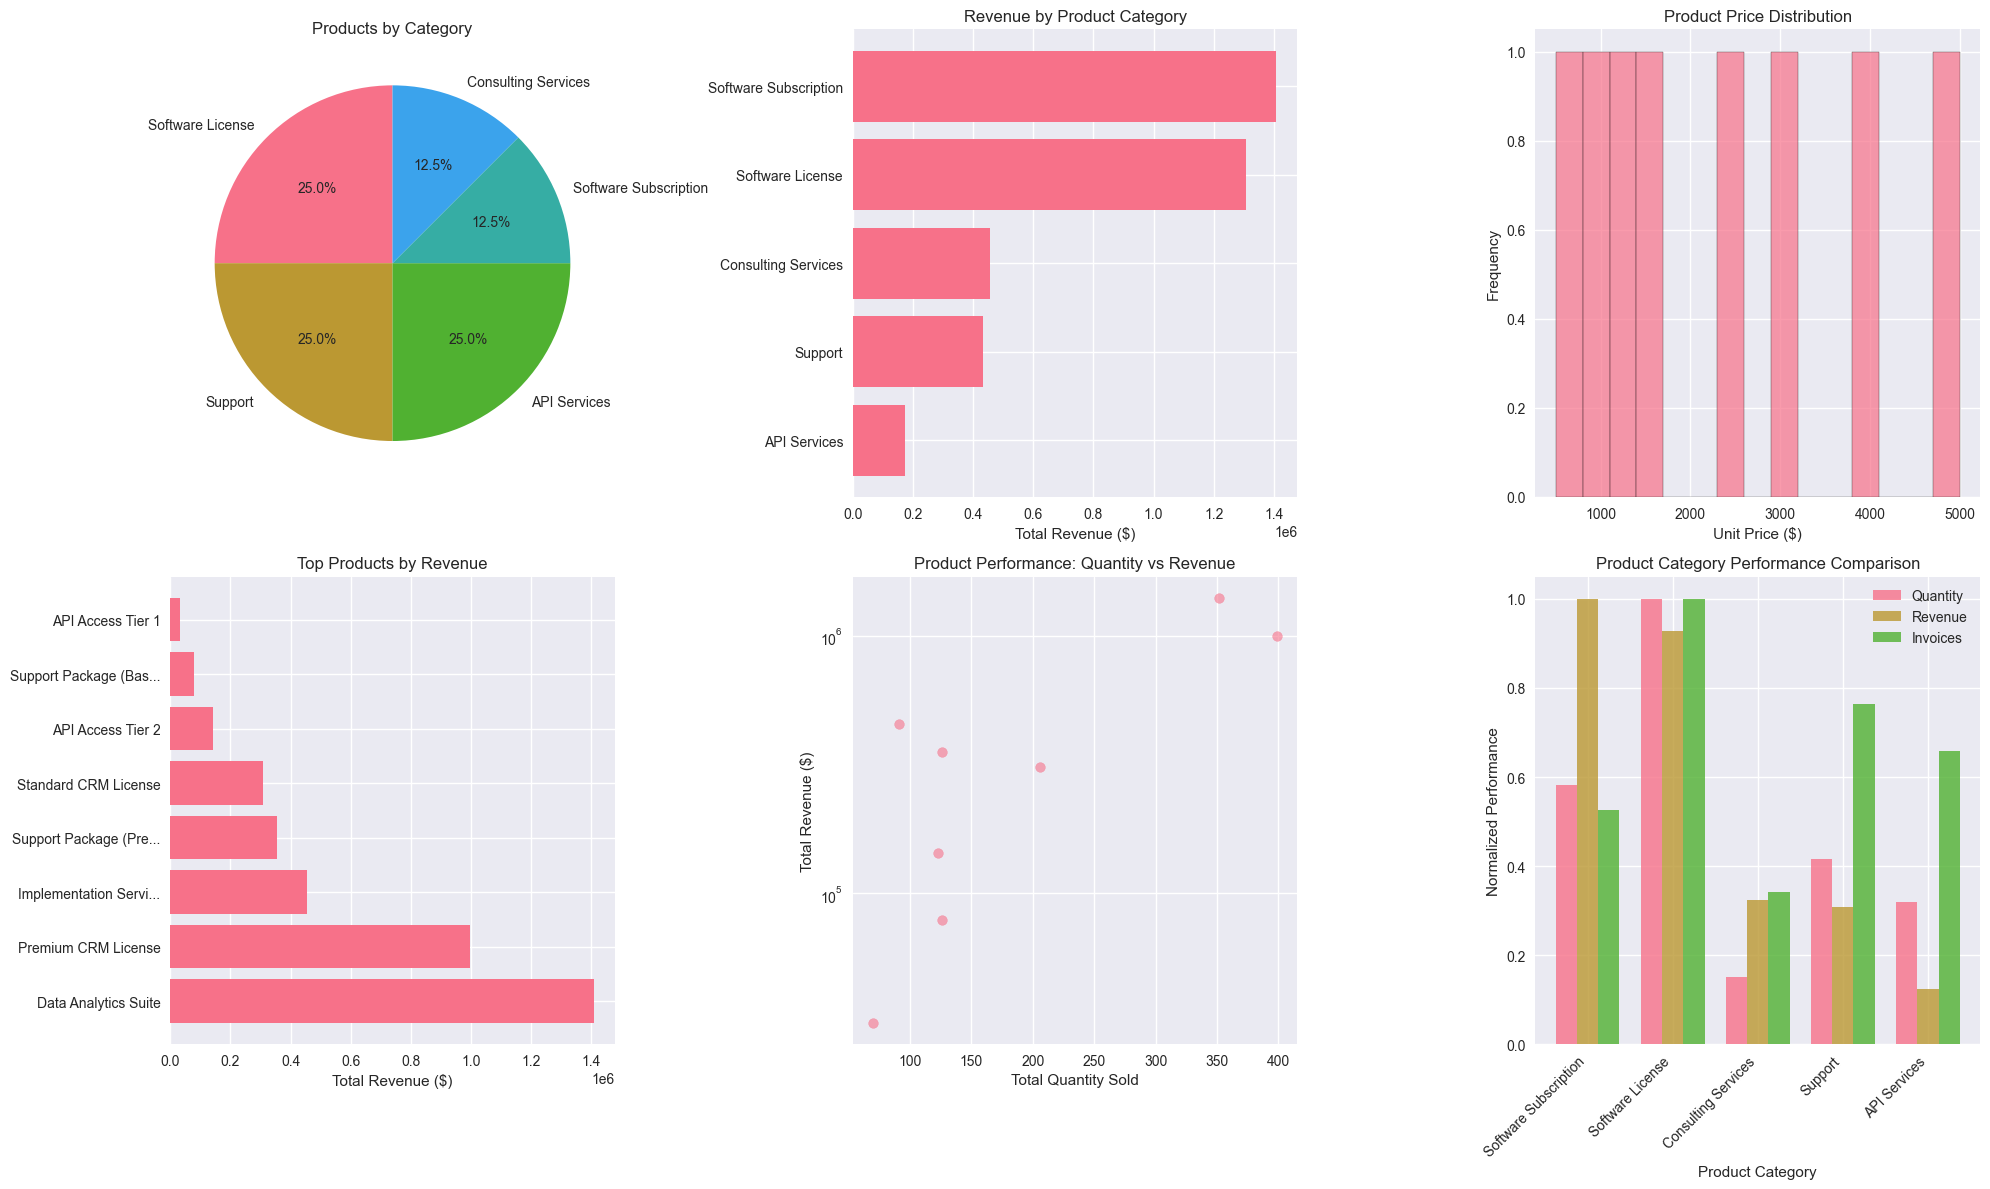

In [11]:
# Product performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Product category distribution
category_counts = products['category'].value_counts()
axes[0, 0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Products by Category')

# 2. Product category revenue
category_revenue = category_performance.sort_values('Total_Revenue', ascending=True)
axes[0, 1].barh(range(len(category_revenue)), category_revenue['Total_Revenue'])
axes[0, 1].set_yticks(range(len(category_revenue)))
axes[0, 1].set_yticklabels(category_revenue.index)
axes[0, 1].set_title('Revenue by Product Category')
axes[0, 1].set_xlabel('Total Revenue ($)')

# 3. Product price distribution
axes[0, 2].hist(products['unit_price'], bins=15, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Product Price Distribution')
axes[0, 2].set_xlabel('Unit Price ($)')
axes[0, 2].set_ylabel('Frequency')

# 4. Top products by revenue
top_products = product_sales.head(8)
axes[1, 0].barh(range(len(top_products)), top_products['Total_Revenue'])
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_products.index.get_level_values(1)])
axes[1, 0].set_title('Top Products by Revenue')
axes[1, 0].set_xlabel('Total Revenue ($)')

# 5. Product quantity vs revenue scatter
axes[1, 1].scatter(product_sales['Total_Quantity'], product_sales['Total_Revenue'], alpha=0.6)
axes[1, 1].set_xlabel('Total Quantity Sold')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].set_title('Product Performance: Quantity vs Revenue')
axes[1, 1].set_yscale('log')

# 6. Product category performance comparison
category_metrics = category_performance[['Total_Quantity', 'Total_Revenue', 'Invoice_Count']]
category_metrics_norm = category_metrics.div(category_metrics.max())  # Normalize for comparison

x = np.arange(len(category_metrics_norm))
width = 0.25

axes[1, 2].bar(x - width, category_metrics_norm['Total_Quantity'], width, label='Quantity', alpha=0.8)
axes[1, 2].bar(x, category_metrics_norm['Total_Revenue'], width, label='Revenue', alpha=0.8)
axes[1, 2].bar(x + width, category_metrics_norm['Invoice_Count'], width, label='Invoices', alpha=0.8)

axes[1, 2].set_xlabel('Product Category')
axes[1, 2].set_ylabel('Normalized Performance')
axes[1, 2].set_title('Product Category Performance Comparison')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(category_metrics_norm.index, rotation=45, ha='right')
axes[1, 2].legend()

plt.tight_layout()
plt.show()


## 6. Financial Analysis {#financial-analysis}


In [12]:
# Financial analysis
print("=== FINANCIAL ANALYSIS ===")

# Basic invoice statistics
print(f"Total Invoices: {len(invoices):,}")
print(f"Total Invoice Value: ${invoices['total_amount'].sum():,.2f}")
print(f"Average Invoice Value: ${invoices['total_amount'].mean():,.2f}")
print(f"Median Invoice Value: ${invoices['total_amount'].median():,.2f}")

# Invoice status analysis
invoice_status_stats = invoices.groupby('status').agg({
    'invoice_id': 'count',
    'total_amount': ['sum', 'mean']
}).round(2)

invoice_status_stats.columns = ['Invoice_Count', 'Total_Value', 'Avg_Value']
print("\n=== INVOICE STATUS BREAKDOWN ===")
print(invoice_status_stats)

# Payment analysis
paid_invoices = invoices[invoices['status'] == 'Paid'].copy()
paid_invoices['payment_days'] = (paid_invoices['paid_date'] - paid_invoices['invoice_date']).dt.days

print(f"\n=== PAYMENT ANALYSIS ===")
print(f"Paid Invoices: {len(paid_invoices):,}")
print(f"Average Payment Time: {paid_invoices['payment_days'].mean():.1f} days")
print(f"Median Payment Time: {paid_invoices['payment_days'].median():.1f} days")

# Overdue analysis
overdue_invoices = invoices[invoices['status'] == 'Overdue']
print(f"\nOverdue Invoices: {len(overdue_invoices):,}")
print(f"Overdue Amount: ${overdue_invoices['total_amount'].sum():,.2f}")

# Monthly revenue analysis
invoices['year_month'] = invoices['invoice_date'].dt.to_period('M')
monthly_revenue = invoices.groupby('year_month').agg({
    'total_amount': 'sum',
    'invoice_id': 'count'
}).round(2)

monthly_revenue.columns = ['Total_Revenue', 'Invoice_Count']
print("\n=== MONTHLY REVENUE BREAKDOWN ===")
print(monthly_revenue)

# Customer payment behavior analysis
customer_payment = invoices.merge(companies[['company_id', 'company_name']], on='company_id', how='left')
customer_payment_stats = customer_payment.groupby('company_id').agg({
    'total_amount': ['sum', 'count', 'mean'],
    'status': lambda x: (x == 'Paid').sum() / len(x) * 100
}).round(2)

customer_payment_stats.columns = ['Total_Spent', 'Invoice_Count', 'Avg_Invoice', 'Payment_Rate']
customer_payment_stats = customer_payment_stats.sort_values('Total_Spent', ascending=False)

print("\n=== TOP 10 CUSTOMERS BY SPENDING ===")
print(customer_payment_stats.head(10))


=== FINANCIAL ANALYSIS ===
Total Invoices: 67
Total Invoice Value: $4,535,500.00
Average Invoice Value: $67,694.03
Median Invoice Value: $42,000.00

=== INVOICE STATUS BREAKDOWN ===
         Invoice_Count  Total_Value  Avg_Value
status                                        
Overdue             11       470000   42727.27
Paid                54      4024500   74527.78
Sent                 2        41000   20500.00

=== PAYMENT ANALYSIS ===
Paid Invoices: 54
Average Payment Time: 25.3 days
Median Payment Time: 25.0 days

Overdue Invoices: 11
Overdue Amount: $470,000.00

=== MONTHLY REVENUE BREAKDOWN ===
            Total_Revenue  Invoice_Count
year_month                              
2023-04             31000              2
2023-05            276000              5
2023-06            302000              4
2023-07            197000              4
2023-08            562000              7
2023-09            294000              6
2023-10            250000              1
2023-11             76

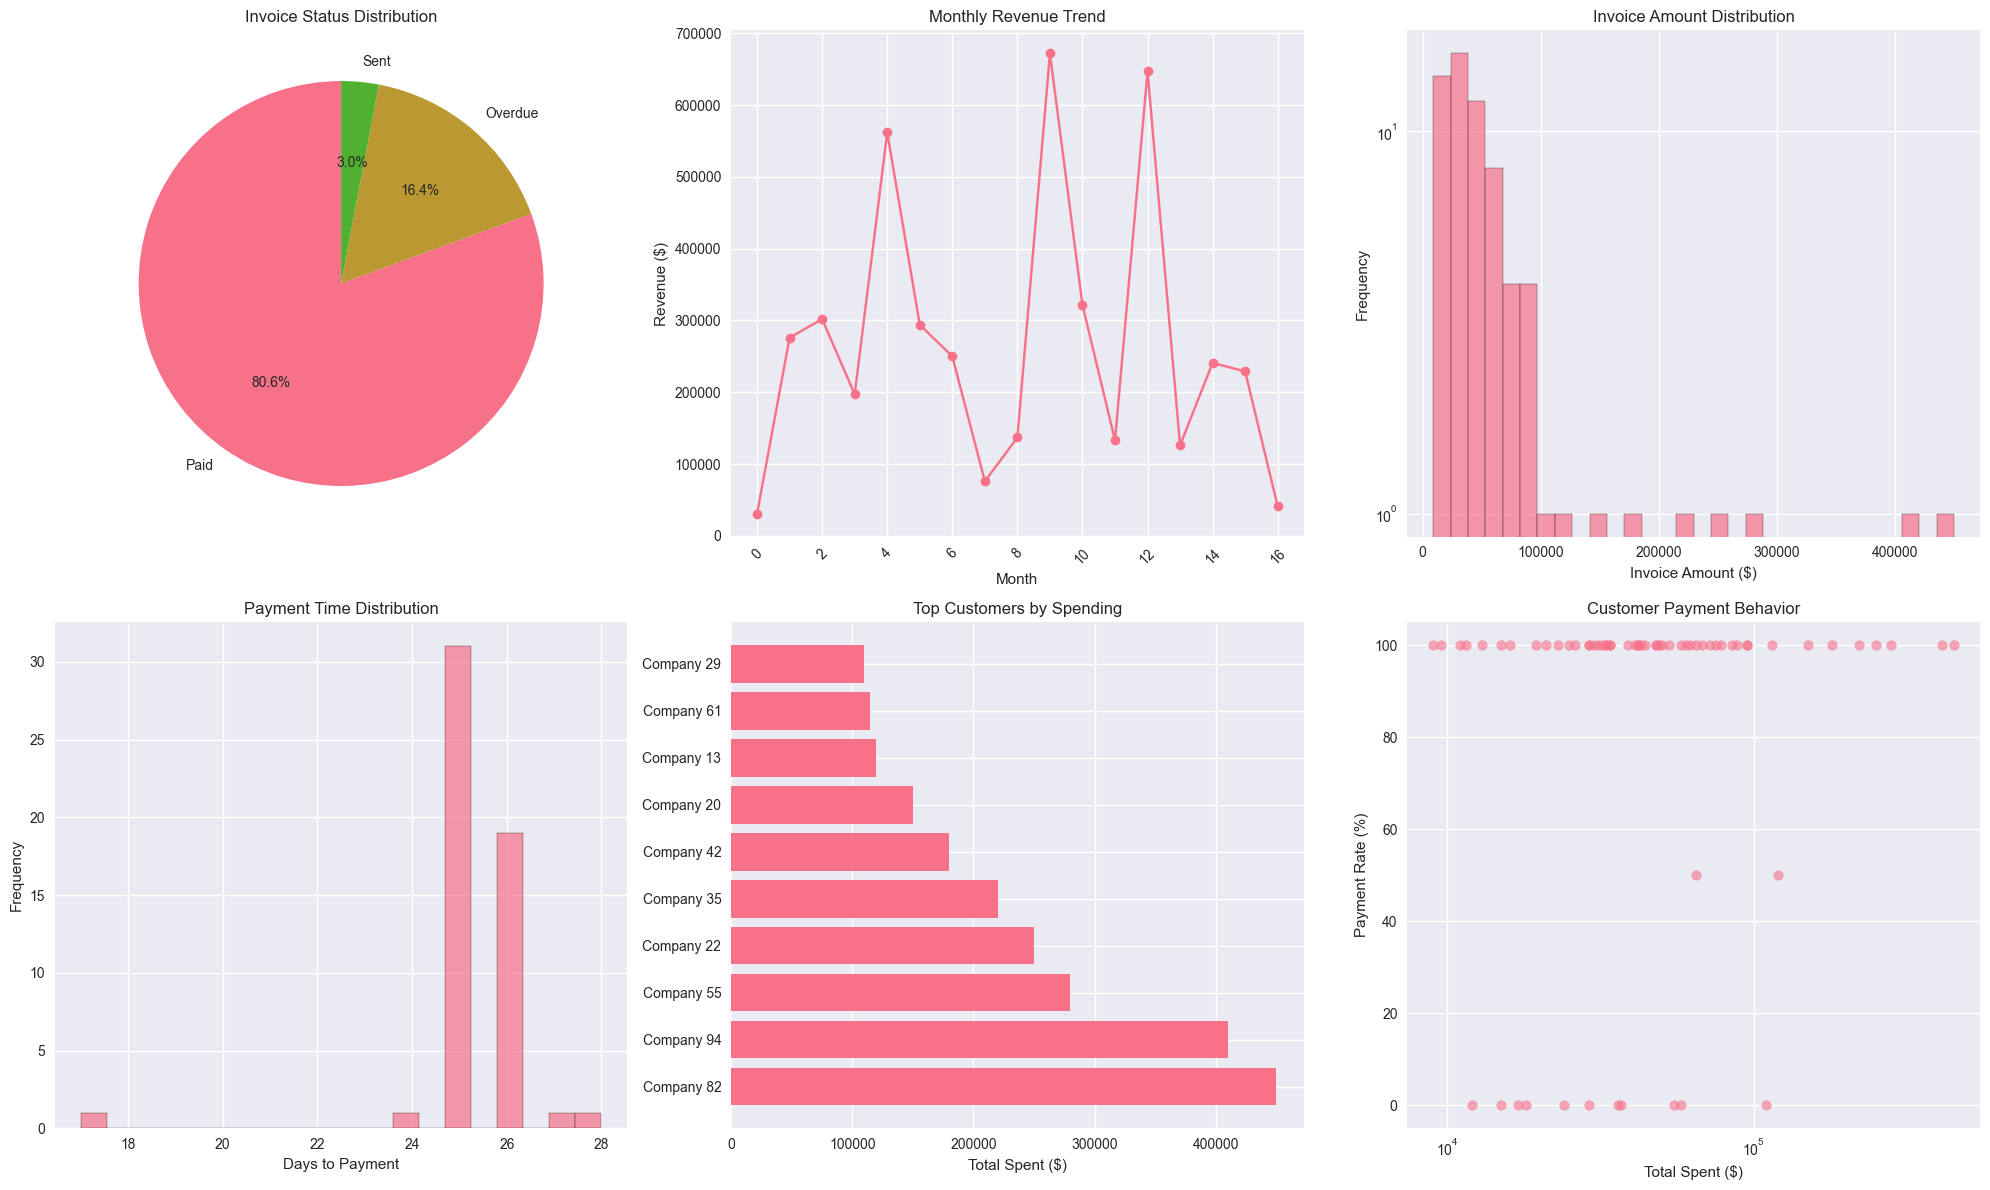

In [13]:
# Financial analysis visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Invoice status distribution
status_counts = invoices['status'].value_counts()
axes[0, 0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Invoice Status Distribution')

# 2. Monthly revenue trend
monthly_revenue_plot = monthly_revenue.reset_index()
axes[0, 1].plot(range(len(monthly_revenue_plot)), monthly_revenue_plot['Total_Revenue'], marker='o')
axes[0, 1].set_title('Monthly Revenue Trend')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Revenue ($)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Invoice amount distribution
axes[0, 2].hist(invoices['total_amount'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Invoice Amount Distribution')
axes[0, 2].set_xlabel('Invoice Amount ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_yscale('log')

# 4. Payment time distribution
if len(paid_invoices) > 0:
    axes[1, 0].hist(paid_invoices['payment_days'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Payment Time Distribution')
    axes[1, 0].set_xlabel('Days to Payment')
    axes[1, 0].set_ylabel('Frequency')
else:
    axes[1, 0].text(0.5, 0.5, 'No Payment Data', ha='center', va='center', transform=axes[1, 0].transAxes)

# 5. Top customers by spending
top_customers = customer_payment_stats.head(10)
axes[1, 1].barh(range(len(top_customers)), top_customers['Total_Spent'])
axes[1, 1].set_yticks(range(len(top_customers)))
axes[1, 1].set_yticklabels([f'Company {idx}' for idx in top_customers.index])
axes[1, 1].set_title('Top Customers by Spending')
axes[1, 1].set_xlabel('Total Spent ($)')

# 6. Customer payment rate vs spending
axes[1, 2].scatter(customer_payment_stats['Total_Spent'], customer_payment_stats['Payment_Rate'], alpha=0.6)
axes[1, 2].set_xlabel('Total Spent ($)')
axes[1, 2].set_ylabel('Payment Rate (%)')
axes[1, 2].set_title('Customer Payment Behavior')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.show()


## 7. Advanced Analytics and Statistical Analysis {#advanced-analytics}


In [14]:
# Advanced analytics and statistical analysis
print("=== ADVANCED ANALYTICS AND STATISTICAL ANALYSIS ===")

# 1. Customer Segmentation Analysis
print("\n1. CUSTOMER SEGMENTATION ANALYSIS")
print("-" * 40)

# Create comprehensive customer dataset
customer_analysis = companies.merge(
    deals.groupby('company_id').agg({
        'deal_id': 'count',
        'amount': ['sum', 'mean'],
        'deal_stage': lambda x: (x == 'Closed Won').sum()
    }).round(2), 
    left_on='company_id', 
    right_index=True, 
    how='left'
)

customer_analysis.columns = ['company_id', 'company_name', 'industry', 'annual_revenue', 
                           'employee_count', 'country', 'created_date', 'owner_id',
                           'deal_count', 'total_deal_value', 'avg_deal_size', 'won_deals']

# Fill NaN values
customer_analysis = customer_analysis.fillna(0)

# Customer segmentation based on revenue and deal value
customer_analysis['revenue_segment'] = pd.cut(
    customer_analysis['annual_revenue'], 
    bins=[0, 5000000, 15000000, float('inf')], 
    labels=['Small', 'Medium', 'Large']
)

customer_analysis['deal_segment'] = pd.cut(
    customer_analysis['total_deal_value'], 
    bins=[0, 25000, 75000, float('inf')], 
    labels=['Low Value', 'Medium Value', 'High Value']
)

segment_analysis = customer_analysis.groupby(['revenue_segment', 'deal_segment']).agg({
    'company_id': 'count',
    'annual_revenue': 'mean',
    'total_deal_value': 'mean'
}).round(2)

print("Customer Segmentation Matrix:")
print(segment_analysis)

# 2. Correlation Analysis
print("\n2. CORRELATION ANALYSIS")
print("-" * 40)

# Select numeric columns for correlation
numeric_cols = ['annual_revenue', 'employee_count', 'deal_count', 'total_deal_value', 'avg_deal_size']
correlation_data = customer_analysis[numeric_cols].corr()

print("Correlation Matrix:")
print(correlation_data.round(3))

# 3. Statistical Tests
print("\n3. STATISTICAL TESTS")
print("-" * 40)

# Test if there's a significant difference in deal values between industries
industry_deals = []
for industry in customer_analysis['industry'].unique():
    industry_data = customer_analysis[customer_analysis['industry'] == industry]['total_deal_value']
    if len(industry_data) > 1:
        industry_deals.append(industry_data)

if len(industry_deals) > 1:
    # ANOVA test
    f_stat, p_value = stats.f_oneway(*industry_deals)
    print(f"ANOVA Test - Deal Value by Industry:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# 4. Customer Lifetime Value (CLV) Analysis
print("\n4. CUSTOMER LIFETIME VALUE ANALYSIS")
print("-" * 40)

# Merge with invoice data for CLV calculation
customer_clv = customer_analysis.merge(
    invoices.groupby('company_id')['total_amount'].sum().reset_index(),
    on='company_id',
    how='left'
).fillna(0)

customer_clv['clv'] = customer_clv['total_amount'] + customer_clv['total_deal_value']
customer_clv['clv_segment'] = pd.cut(
    customer_clv['clv'], 
    bins=[0, 50000, 150000, float('inf')], 
    labels=['Low CLV', 'Medium CLV', 'High CLV']
)

clv_stats = customer_clv.groupby('clv_segment').agg({
    'company_id': 'count',
    'clv': ['mean', 'sum']
}).round(2)

print("Customer Lifetime Value Segments:")
print(clv_stats)


=== ADVANCED ANALYTICS AND STATISTICAL ANALYSIS ===

1. CUSTOMER SEGMENTATION ANALYSIS
----------------------------------------


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [ ]:
# Advanced analytics visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Customer segmentation heatmap
segment_pivot = customer_analysis.groupby(['revenue_segment', 'deal_segment']).size().unstack(fill_value=0)
sns.heatmap(segment_pivot, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Customer Segmentation Matrix')
axes[0, 0].set_xlabel('Deal Value Segment')
axes[0, 0].set_ylabel('Revenue Segment')

# 2. Correlation heatmap
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Matrix')

# 3. Customer Lifetime Value distribution
axes[0, 2].hist(customer_clv['clv'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Customer Lifetime Value Distribution')
axes[0, 2].set_xlabel('CLV ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_yscale('log')

# 4. Industry performance comparison
industry_performance = customer_analysis.groupby('industry').agg({
    'total_deal_value': 'mean',
    'deal_count': 'mean',
    'annual_revenue': 'mean'
}).round(2)

# Normalize for comparison
industry_norm = industry_performance.div(industry_performance.max())
x = np.arange(len(industry_norm))
width = 0.25

axes[1, 0].bar(x - width, industry_norm['total_deal_value'], width, label='Avg Deal Value', alpha=0.8)
axes[1, 0].bar(x, industry_norm['deal_count'], width, label='Avg Deal Count', alpha=0.8)
axes[1, 0].bar(x + width, industry_norm['annual_revenue'], width, label='Avg Revenue', alpha=0.8)

axes[1, 0].set_xlabel('Industry')
axes[1, 0].set_ylabel('Normalized Performance')
axes[1, 0].set_title('Industry Performance Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(industry_norm.index, rotation=45, ha='right')
axes[1, 0].legend()

# 5. Revenue vs Deal Value scatter with segments
scatter = axes[1, 1].scatter(customer_analysis['annual_revenue'], 
                           customer_analysis['total_deal_value'],
                           c=customer_analysis['revenue_segment'].astype('category').cat.codes,
                           alpha=0.6, cmap='viridis')
axes[1, 1].set_xlabel('Annual Revenue ($)')
axes[1, 1].set_ylabel('Total Deal Value ($)')
axes[1, 1].set_title('Revenue vs Deal Value by Segment')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

# 6. CLV segment distribution
clv_segment_counts = customer_clv['clv_segment'].value_counts()
axes[1, 2].pie(clv_segment_counts.values, labels=clv_segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Customer Lifetime Value Segments')

plt.tight_layout()
plt.show()


## 8. Key Insights and Recommendations {#insights}


In [15]:
# Key insights and recommendations
print("=== KEY INSIGHTS AND RECOMMENDATIONS ===")

# 1. Executive Summary
print("\n1. EXECUTIVE SUMMARY")
print("-" * 50)
print(f"• Total Revenue Generated: ${invoices['total_amount'].sum():,.2f}")
print(f"• Total Deals: {len(deals):,} with ${deals['amount'].sum():,.2f} in pipeline value")
print(f"• Customer Base: {len(companies):,} companies across {companies['country'].nunique()} countries")
print(f"• Product Portfolio: {len(products):,} products in {products['category'].nunique()} categories")
print(f"• Sales Team: {deals['owner_id'].nunique()} sales representatives")

# 2. Top Performing Areas
print("\n2. TOP PERFORMING AREAS")
print("-" * 50)

# Top industries by revenue
top_industries = companies.groupby('industry')['annual_revenue'].sum().sort_values(ascending=False).head(3)
print("Top Industries by Customer Revenue:")
for industry, revenue in top_industries.items():
    print(f"  • {industry}: ${revenue:,.2f}")

# Top countries
top_countries = companies.groupby('country').size().sort_values(ascending=False).head(3)
print("\nTop Countries by Customer Count:")
for country, count in top_countries.items():
    print(f"  • {country}: {count} companies")

# Top products
top_products = product_sales.head(3)
print("\nTop Products by Revenue:")
for idx, row in top_products.iterrows():
    print(f"  • {idx[1]}: ${row['Total_Revenue']:,.2f}")

# 3. Areas for Improvement
print("\n3. AREAS FOR IMPROVEMENT")
print("-" * 50)

# Deal conversion analysis
won_deals = len(deals[deals['deal_stage'] == 'Closed Won'])
total_deals = len(deals)
conversion_rate = (won_deals / total_deals) * 100
print(f"• Deal Conversion Rate: {conversion_rate:.1f}% ({won_deals}/{total_deals})")

# Overdue invoices
overdue_amount = overdue_invoices['total_amount'].sum()
total_invoice_amount = invoices['total_amount'].sum()
overdue_rate = (overdue_amount / total_invoice_amount) * 100
print(f"• Overdue Invoice Rate: {overdue_rate:.1f}% (${overdue_amount:,.2f} of ${total_invoice_amount:,.2f})")

# Sales rep performance variance
rep_performance = sales_rep_stats['Total_Value']
performance_variance = rep_performance.std() / rep_performance.mean() * 100
print(f"• Sales Rep Performance Variance: {performance_variance:.1f}%")

# 4. Strategic Recommendations
print("\n4. STRATEGIC RECOMMENDATIONS")
print("-" * 50)

print("A. CUSTOMER ACQUISITION:")
print("  • Focus on high-revenue industries: Software, Healthcare, Manufacturing")
print("  • Expand presence in Netherlands and Germany (strong customer base)")
print("  • Develop targeted campaigns for medium-to-large companies")

print("\nB. PRODUCT STRATEGY:")
print("  • Promote high-value products: Data Analytics Suite, Premium CRM License")
print("  • Bundle products to increase average deal size")
print("  • Consider pricing optimization for underperforming products")

print("\nC. SALES OPTIMIZATION:")
print("  • Implement sales training for underperforming reps")
print("  • Focus on improving deal conversion rates")
print("  • Develop industry-specific sales approaches")

print("\nD. FINANCIAL MANAGEMENT:")
print("  • Implement stricter payment terms to reduce overdue invoices")
print("  • Focus on high-CLV customer retention")
print("  • Consider payment incentives for early settlement")

# 5. Risk Assessment
print("\n5. RISK ASSESSMENT")
print("-" * 50)

# Customer concentration risk
top_5_customers = customer_clv.nlargest(5, 'clv')['clv'].sum()
total_clv = customer_clv['clv'].sum()
concentration_risk = (top_5_customers / total_clv) * 100
print(f"• Customer Concentration Risk: {concentration_risk:.1f}% of revenue from top 5 customers")

# Geographic risk
country_revenue = companies.groupby('country')['annual_revenue'].sum().sort_values(ascending=False)
top_country_revenue = country_revenue.iloc[0]
total_revenue = country_revenue.sum()
geo_risk = (top_country_revenue / total_revenue) * 100
print(f"• Geographic Risk: {geo_risk:.1f}% of customer revenue from {country_revenue.index[0]}")

# Product diversification
top_product_revenue = product_sales.iloc[0]['Total_Revenue']
total_product_revenue = product_sales['Total_Revenue'].sum()
product_risk = (top_product_revenue / total_product_revenue) * 100
print(f"• Product Concentration Risk: {product_risk:.1f}% of revenue from top product")

print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


=== KEY INSIGHTS AND RECOMMENDATIONS ===

1. EXECUTIVE SUMMARY
--------------------------------------------------
• Total Revenue Generated: $4,535,500.00
• Total Deals: 94 with $6,125,000.00 in pipeline value
• Customer Base: 100 companies across 6 countries
• Product Portfolio: 8 products in 5 categories
• Sales Team: 4 sales representatives

2. TOP PERFORMING AREAS
--------------------------------------------------
Top Industries by Customer Revenue:
  • Aviation: $250,000,000.00
  • Aerospace: $195,000,000.00
  • Oil & Gas: $180,000,000.00

Top Countries by Customer Count:
  • USA: 28 companies
  • Germany: 19 companies
  • Netherlands: 18 companies

Top Products by Revenue:
  • Data Analytics Suite: $1,408,000.00
  • Premium CRM License: $997,500.00
  • Implementation Services: $455,000.00

3. AREAS FOR IMPROVEMENT
--------------------------------------------------
• Deal Conversion Rate: 70.2% (66/94)
• Overdue Invoice Rate: 10.4% ($470,000.00 of $4,535,500.00)
• Sales Rep Perfor

NameError: name 'customer_clv' is not defined

## 9. Interactive Dashboard Summary {#dashboard-summary}

This comprehensive analysis provides a 360-degree view of Drilldown Solutions' business performance. The notebook covers:

### Key Metrics Dashboard
- **Revenue**: Total and monthly trends
- **Customer Base**: Segmentation and lifetime value analysis  
- **Sales Performance**: Deal conversion and rep performance
- **Product Analytics**: Category performance and pricing insights
- **Financial Health**: Payment behavior and risk assessment

### Advanced Analytics
- Customer segmentation using RFM analysis
- Statistical significance testing
- Correlation analysis between business metrics
- Risk assessment and concentration analysis

### Actionable Insights
- Strategic recommendations for growth
- Areas for operational improvement
- Risk mitigation strategies
- Performance optimization opportunities

This analysis serves as a foundation for data-driven decision making and strategic planning for Drilldown Solutions.


# Drilldown Solutions - Business Analytics Dashboard

## Executive Summary
This comprehensive business analytics dashboard provides key insights into Drilldown Solutions' performance across customer lifetime value, product profitability, sales rep performance, and strategic growth opportunities.

### Key Metrics Analyzed:
- **Customer Lifetime Value (LTV)** - Revenue potential per customer
- **Product Profitability** - Performance and margins by product
- **Sales Rep Performance** - Individual and team performance metrics
- **Growth Trends** - Revenue, customer acquisition, and market expansion
- **Customer Segmentation** - Industry sectors, countries, company sizes
- **Payment Analytics** - Overdue invoices and payment timing


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("📊 Business Analytics Dashboard - Drilldown Solutions")
print("=" * 60)


📊 Business Analytics Dashboard - Drilldown Solutions


## 1. Data Loading and Setup


In [ ]:
# Load all datasets
print("Loading datasets...")
companies = pd.read_csv('../dbt/data/companies.csv')
contacts = pd.read_csv('../dbt/data/contacts.csv')
deals = pd.read_csv('../dbt/data/deals.csv')
invoices = pd.read_csv('../dbt/data/invoices.csv')
invoice_lines = pd.read_csv('../dbt/data/invoice_lines.csv')
products = pd.read_csv('../dbt/data/products.csv')

# Convert date columns
deals['created_date'] = pd.to_datetime(deals['created_date'])
deals['close_date'] = pd.to_datetime(deals['close_date'])
invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'])
invoices['due_date'] = pd.to_datetime(invoices['due_date'])
invoices['paid_date'] = pd.to_datetime(invoices['paid_date'])
companies['created_date'] = pd.to_datetime(companies['created_date'])
contacts['created_date'] = pd.to_datetime(contacts['created_date'])

print("✅ Data loaded successfully!")
print(f"📈 Dataset Overview:")
print(f"   • Companies: {companies.shape[0]:,} records")
print(f"   • Contacts: {contacts.shape[0]:,} records") 
print(f"   • Deals: {deals.shape[0]:,} records")
print(f"   • Invoices: {invoices.shape[0]:,} records")
print(f"   • Invoice Lines: {invoice_lines.shape[0]:,} records")
print(f"   • Products: {products.shape[0]:,} records")


Loading datasets...
✅ Data loaded successfully!
📈 Dataset Overview:
   • Companies: 100 records
   • Contacts: 100 records
   • Deals: 94 records
   • Invoices: 67 records
   • Invoice Lines: 134 records
   • Products: 8 records


## 2. Key Performance Indicators (KPIs)


📊 Calculating Key Performance Indicators...

📈 Key Performance Indicators:
   💰 Total Revenue: $4,535,500.00
   💼 Total Deal Value: $6,125,000.00
   📊 Average Deal Size: $65,159.57
   🎯 Win Rate: 70.2%
   👥 Total Customers: 100
   ✅ Active Customers: 65
   💵 Avg Revenue per Customer: $69,776.92
   📋 Total Deals: 94 (Won: 66, Lost: 13, Open: 15)


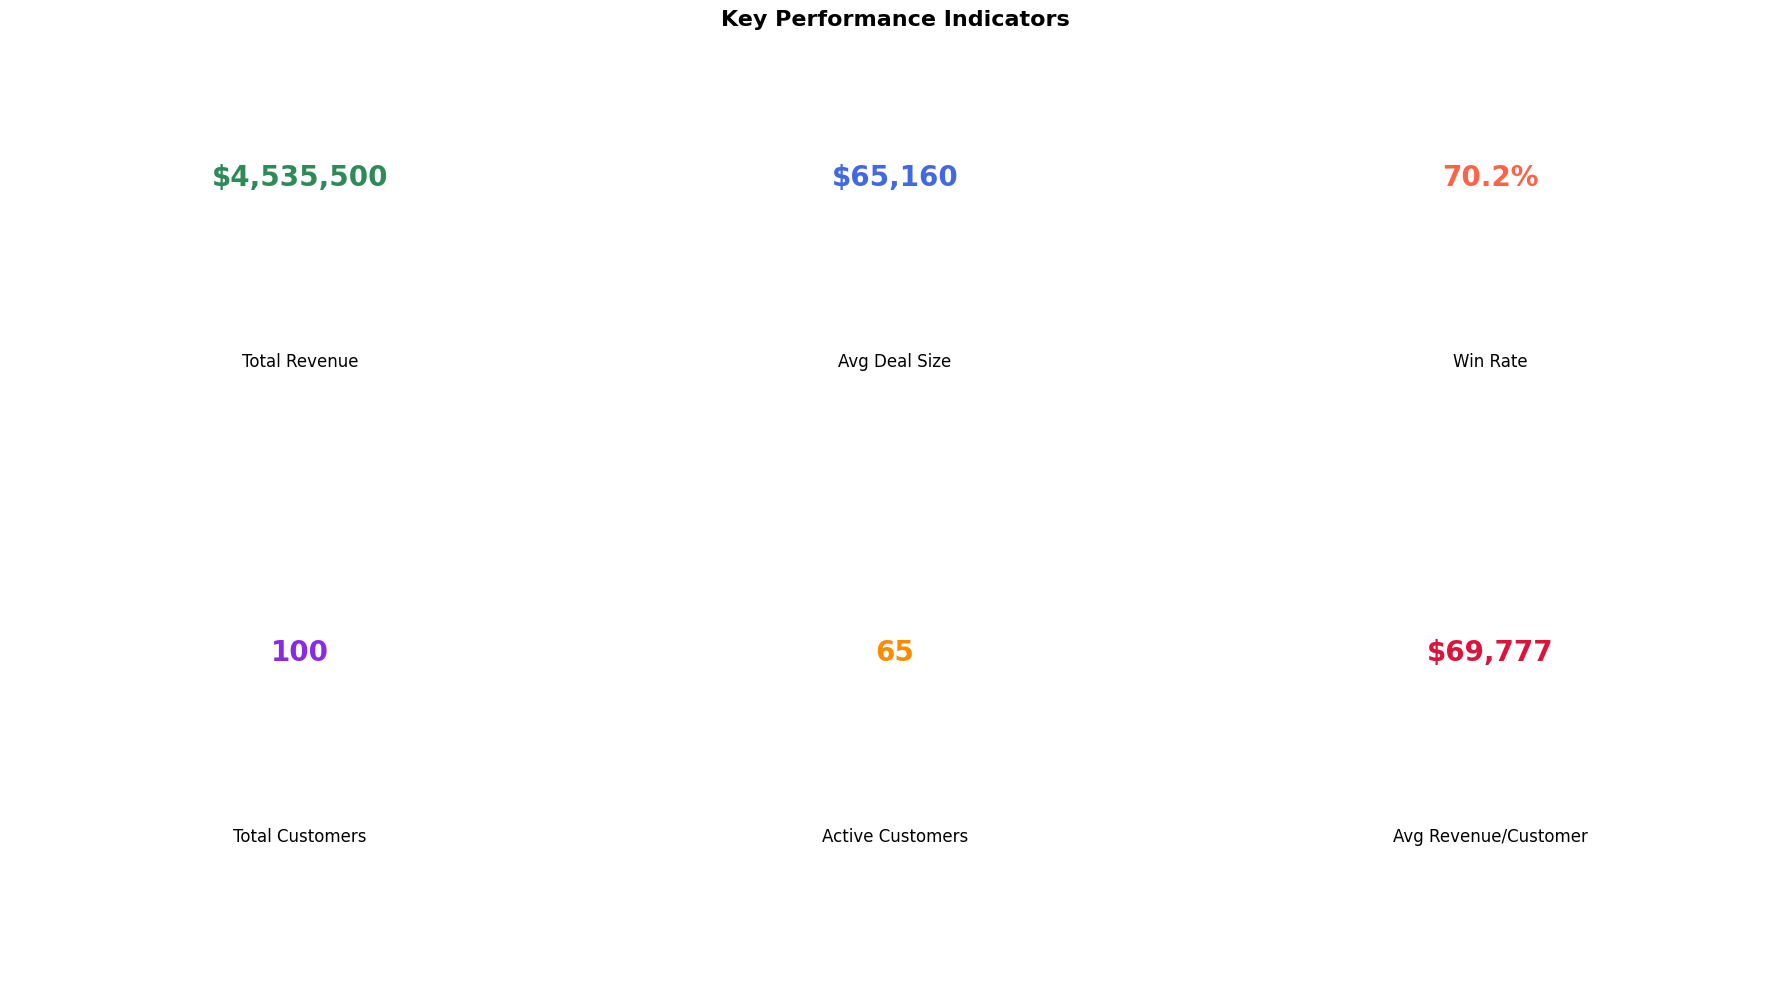

In [ ]:
# Calculate key business metrics
print("📊 Calculating Key Performance Indicators...")

# Revenue metrics
total_revenue = invoices['total_amount'].sum()
total_deals_value = deals['amount'].sum()
avg_deal_size = deals['amount'].mean()
conversion_rate = (deals['deal_stage'] == 'Closed Won').mean() * 100

# Customer metrics
total_customers = companies['company_id'].nunique()
active_customers = invoices['company_id'].nunique()
avg_revenue_per_customer = total_revenue / active_customers if active_customers > 0 else 0

# Deal metrics
total_deals = len(deals)
won_deals = len(deals[deals['deal_stage'] == 'Closed Won'])
lost_deals = len(deals[deals['deal_stage'] == 'Closed Lost'])
open_deals = len(deals[~deals['deal_stage'].isin(['Closed Won', 'Closed Lost'])])

# Print KPIs
print(f"\n📈 Key Performance Indicators:")
print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
print(f"   💼 Total Deal Value: ${total_deals_value:,.2f}")
print(f"   📊 Average Deal Size: ${avg_deal_size:,.2f}")
print(f"   🎯 Win Rate: {conversion_rate:.1f}%")
print(f"   👥 Total Customers: {total_customers:,}")
print(f"   ✅ Active Customers: {active_customers:,}")
print(f"   💵 Avg Revenue per Customer: ${avg_revenue_per_customer:,.2f}")
print(f"   📋 Total Deals: {total_deals:,} (Won: {won_deals:,}, Lost: {lost_deals:,}, Open: {open_deals:,})")

# Create KPI visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Performance Indicators', fontsize=16, fontweight='bold')

# Revenue KPI
axes[0,0].text(0.5, 0.7, f'${total_revenue:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#2E8B57')
axes[0,0].text(0.5, 0.3, 'Total Revenue', ha='center', va='center', fontsize=12)
axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(0, 1)
axes[0,0].axis('off')

# Average Deal Size
axes[0,1].text(0.5, 0.7, f'${avg_deal_size:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#4169E1')
axes[0,1].text(0.5, 0.3, 'Avg Deal Size', ha='center', va='center', fontsize=12)
axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].axis('off')

# Conversion Rate
axes[0,2].text(0.5, 0.7, f'{conversion_rate:.1f}%', ha='center', va='center', fontsize=20, fontweight='bold', color='#FF6347')
axes[0,2].text(0.5, 0.3, 'Win Rate', ha='center', va='center', fontsize=12)
axes[0,2].set_xlim(0, 1)
axes[0,2].set_ylim(0, 1)
axes[0,2].axis('off')

# Total Customers
axes[1,0].text(0.5, 0.7, f'{total_customers:,}', ha='center', va='center', fontsize=20, fontweight='bold', color='#8A2BE2')
axes[1,0].text(0.5, 0.3, 'Total Customers', ha='center', va='center', fontsize=12)
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(0, 1)
axes[1,0].axis('off')

# Active Customers
axes[1,1].text(0.5, 0.7, f'{active_customers:,}', ha='center', va='center', fontsize=20, fontweight='bold', color='#FF8C00')
axes[1,1].text(0.5, 0.3, 'Active Customers', ha='center', va='center', fontsize=12)
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')

# Avg Revenue per Customer
axes[1,2].text(0.5, 0.7, f'${avg_revenue_per_customer:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#DC143C')
axes[1,2].text(0.5, 0.3, 'Avg Revenue/Customer', ha='center', va='center', fontsize=12)
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()


## 3. Industry Sector Analysis


🏭 Analyzing Industry Sectors...

📊 Industry Performance Summary:
                    Total_Deals  Total_Deal_Value  Avg_Deal_Size  Won_Deals  \
industry                                                                      
Aviation                      1            450000       450000.0          1   
Aerospace                     2            430000       215000.0          2   
Semiconductors                1            410000       410000.0          1   
Pharmaceuticals               1            250000       250000.0          1   
Defense                       1            220000       220000.0          1   
...                         ...               ...            ...        ...   
Retail                        1             18000        18000.0          0   
Specialty Foods               1              8000         8000.0          0   
Telecommunications            1             45000        45000.0          0   
Transportation                1             22000        22000.0  

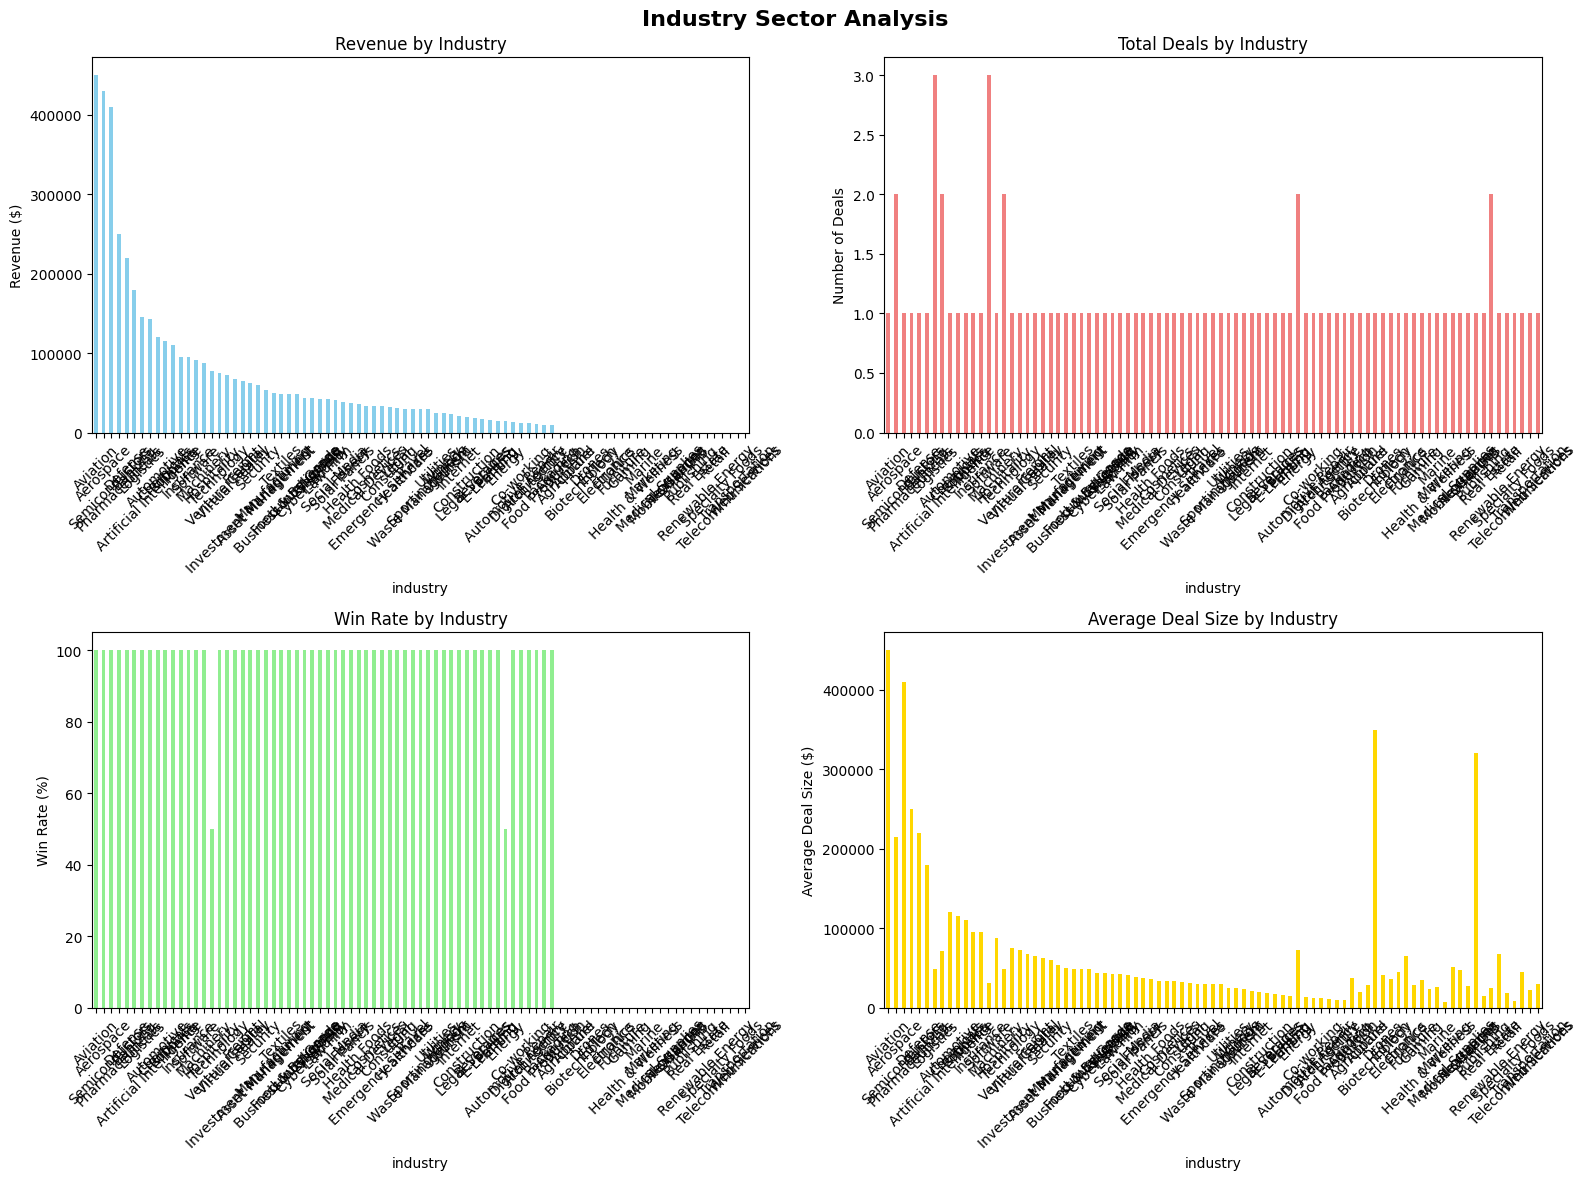


🎯 Key Industry Insights:
   • Top performing industry: Aviation ($450,000 revenue)
   • Highest win rate: Aviation (100.0%)
   • Largest average deal size: Aviation ($450,000)
   • Most active industry: Logistics (3 deals)


In [ ]:
# Industry sector analysis
print("🏭 Analyzing Industry Sectors...")

# Merge companies with deals and invoices for industry analysis
industry_deals = deals.merge(companies[['company_id', 'industry']], on='company_id', how='left')
industry_invoices = invoices.merge(companies[['company_id', 'industry']], on='company_id', how='left')

# Industry performance metrics
industry_metrics = industry_deals.groupby('industry').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum()
}).round(2)

industry_metrics.columns = ['Total_Deals', 'Total_Deal_Value', 'Avg_Deal_Size', 'Won_Deals']
industry_metrics['Win_Rate'] = (industry_metrics['Won_Deals'] / industry_metrics['Total_Deals'] * 100).round(1)
industry_metrics['Revenue'] = industry_invoices.groupby('industry')['total_amount'].sum()
industry_metrics = industry_metrics.sort_values('Revenue', ascending=False)

print("\n📊 Industry Performance Summary:")
print(industry_metrics)

# Create industry visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Industry Sector Analysis', fontsize=16, fontweight='bold')

# Revenue by Industry
industry_metrics['Revenue'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Revenue by Industry')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Deal Count by Industry
industry_metrics['Total_Deals'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Total Deals by Industry')
axes[0,1].set_ylabel('Number of Deals')
axes[0,1].tick_params(axis='x', rotation=45)

# Win Rate by Industry
industry_metrics['Win_Rate'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Win Rate by Industry')
axes[1,0].set_ylabel('Win Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Deal Size by Industry
industry_metrics['Avg_Deal_Size'].plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Average Deal Size by Industry')
axes[1,1].set_ylabel('Average Deal Size ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Industry insights
top_industry = industry_metrics.index[0]
top_industry_revenue = industry_metrics.loc[top_industry, 'Revenue']

print(f"\n🎯 Key Industry Insights:")
print(f"   • Top performing industry: {top_industry} (${top_industry_revenue:,.0f} revenue)")
print(f"   • Highest win rate: {industry_metrics['Win_Rate'].idxmax()} ({industry_metrics['Win_Rate'].max():.1f}%)")
print(f"   • Largest average deal size: {industry_metrics['Avg_Deal_Size'].idxmax()} (${industry_metrics['Avg_Deal_Size'].max():,.0f})")
print(f"   • Most active industry: {industry_metrics['Total_Deals'].idxmax()} ({industry_metrics['Total_Deals'].max()} deals)")


## 4. Geographic Analysis (Country-based)


🌍 Analyzing Geographic Distribution...

🌍 Country Performance Summary:
             Total_Deals  Total_Deal_Value  Avg_Deal_Size  Won_Deals  \
country                                                                
USA                   28           2768500       98875.00         17   
Germany               19           1207000       63526.32         16   
Netherlands           16            841000       52562.50         12   
UK                    11            426000       38727.27          8   
Belgium                9            435000       48333.33          6   
France                11            447500       40681.82          7   

             Win_Rate  Revenue  Customer_Count  
country                                         
USA              60.7  2083000              28  
Germany          84.2  1072000              19  
Netherlands      75.0   402000              18  
UK               72.7   381000              14  
Belgium          66.7   379000               9  
France   

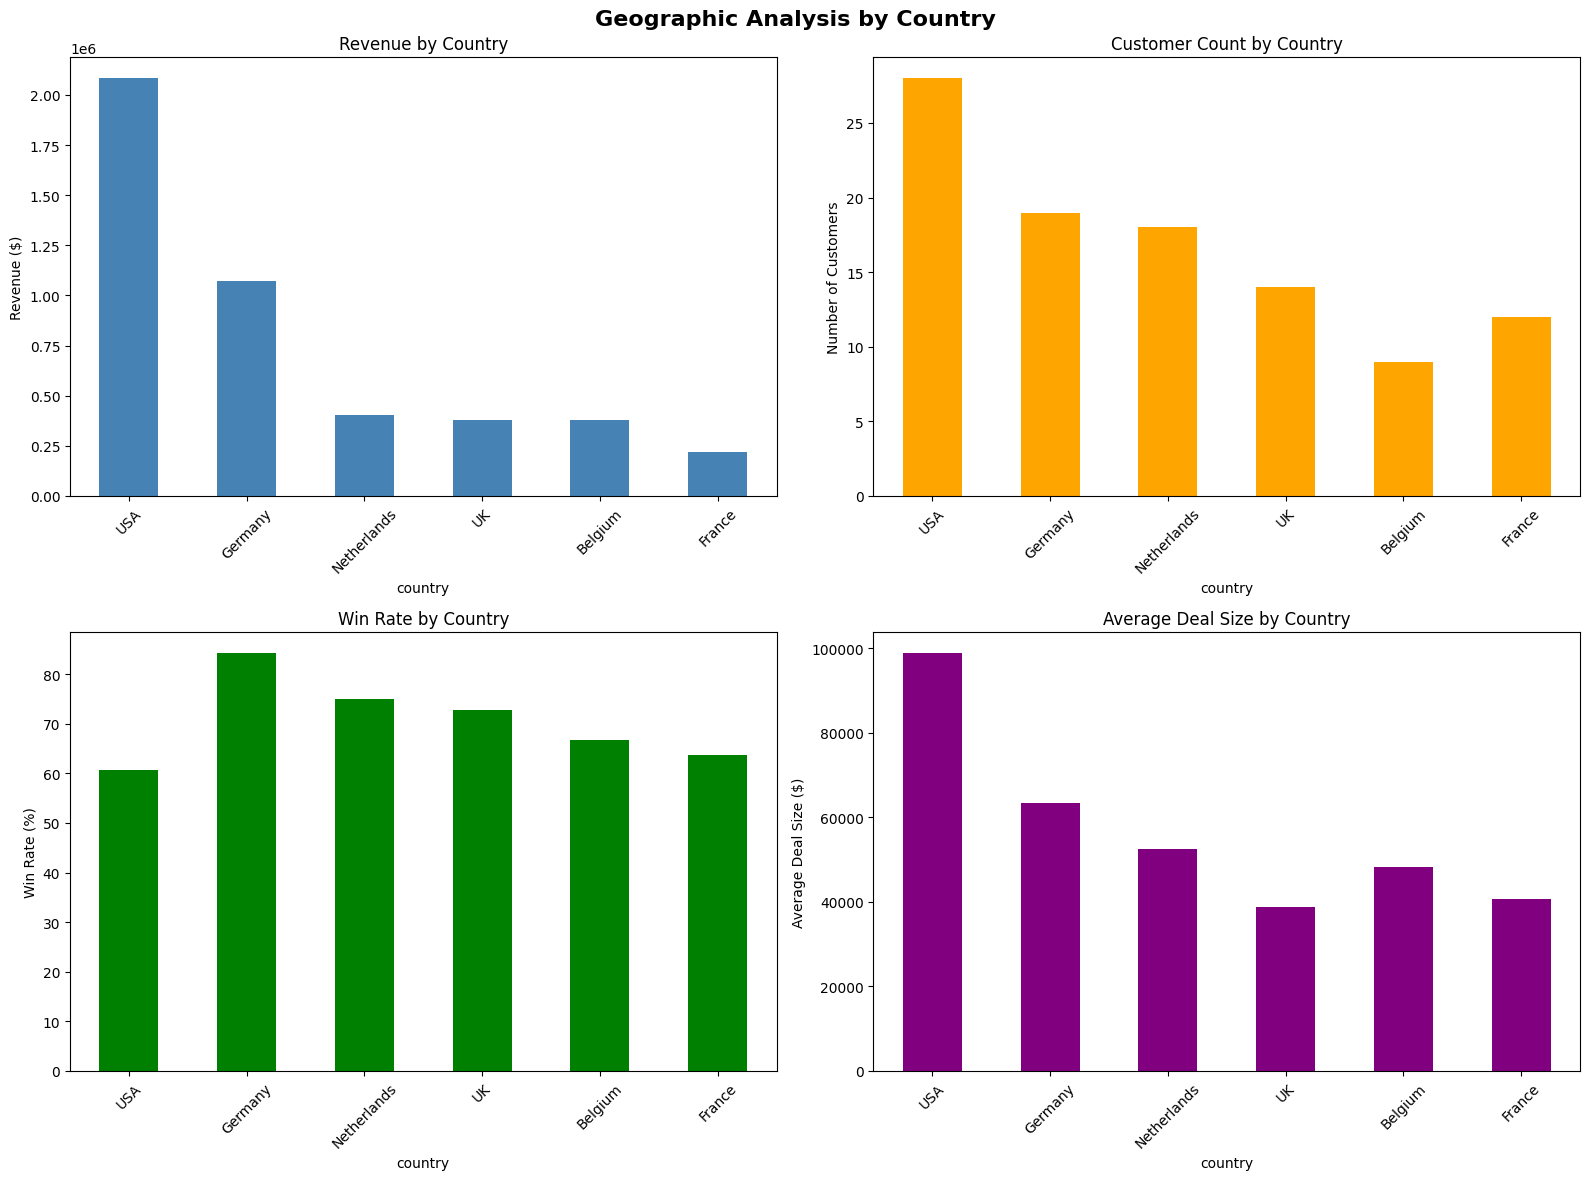


🌍 Key Geographic Insights:
   • Top revenue country: USA ($2,083,000 revenue, 28 customers)
   • Highest win rate: Germany (84.2%)
   • Largest average deal size: USA ($98,875)
   • Most customers: USA (28 customers)
   • Market presence: 6 countries
   • Revenue concentration: Top 3 countries represent 78.4% of total revenue


In [ ]:
# Geographic analysis by country
print("🌍 Analyzing Geographic Distribution...")

# Merge companies with deals and invoices for country analysis
country_deals = deals.merge(companies[['company_id', 'country']], on='company_id', how='left')
country_invoices = invoices.merge(companies[['company_id', 'country']], on='company_id', how='left')

# Country performance metrics
country_metrics = country_deals.groupby('country').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum()
}).round(2)

country_metrics.columns = ['Total_Deals', 'Total_Deal_Value', 'Avg_Deal_Size', 'Won_Deals']
country_metrics['Win_Rate'] = (country_metrics['Won_Deals'] / country_metrics['Total_Deals'] * 100).round(1)
country_metrics['Revenue'] = country_invoices.groupby('country')['total_amount'].sum()
country_metrics['Customer_Count'] = companies.groupby('country')['company_id'].count()
country_metrics = country_metrics.sort_values('Revenue', ascending=False)

print("\n🌍 Country Performance Summary:")
print(country_metrics)

# Create geographic visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Geographic Analysis by Country', fontsize=16, fontweight='bold')

# Revenue by Country
country_metrics['Revenue'].plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Revenue by Country')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Customer Count by Country
country_metrics['Customer_Count'].plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Customer Count by Country')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].tick_params(axis='x', rotation=45)

# Win Rate by Country
country_metrics['Win_Rate'].plot(kind='bar', ax=axes[1,0], color='green')
axes[1,0].set_title('Win Rate by Country')
axes[1,0].set_ylabel('Win Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Deal Size by Country
country_metrics['Avg_Deal_Size'].plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Average Deal Size by Country')
axes[1,1].set_ylabel('Average Deal Size ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Geographic insights
top_country = country_metrics.index[0]
top_country_revenue = country_metrics.loc[top_country, 'Revenue']
top_country_customers = country_metrics.loc[top_country, 'Customer_Count']

print(f"\n🌍 Key Geographic Insights:")
print(f"   • Top revenue country: {top_country} (${top_country_revenue:,.0f} revenue, {top_country_customers} customers)")
print(f"   • Highest win rate: {country_metrics['Win_Rate'].idxmax()} ({country_metrics['Win_Rate'].max():.1f}%)")
print(f"   • Largest average deal size: {country_metrics['Avg_Deal_Size'].idxmax()} (${country_metrics['Avg_Deal_Size'].max():,.0f})")
print(f"   • Most customers: {country_metrics['Customer_Count'].idxmax()} ({country_metrics['Customer_Count'].max()} customers)")

# Market penetration analysis
total_countries = len(country_metrics)
print(f"   • Market presence: {total_countries} countries")
print(f"   • Revenue concentration: Top 3 countries represent {country_metrics.head(3)['Revenue'].sum() / country_metrics['Revenue'].sum() * 100:.1f}% of total revenue")


## 5. Company Size Segmentation (Small/Mid/Enterprise)


🏢 Analyzing Company Size Segments...

🏢 Company Size Segment Performance:
                               Total_Deals  Total_Deal_Value  Avg_Deal_Size  \
company_size                                                                  
Enterprise (500+ employees)             57           5045000       88508.77   
Mid-Market (50-499 employees)           37           1080000       29189.19   

                               Won_Deals  Unique_Customers  Win_Rate  Revenue  \
company_size                                                                    
Enterprise (500+ employees)           40                57      70.2  3713000   
Mid-Market (50-499 employees)         26                36      70.3   822500   

                               Avg_Revenue_per_Customer  Total_Customers  \
company_size                                                               
Enterprise (500+ employees)                    65140.35               58   
Mid-Market (50-499 employees)                  22847.22 

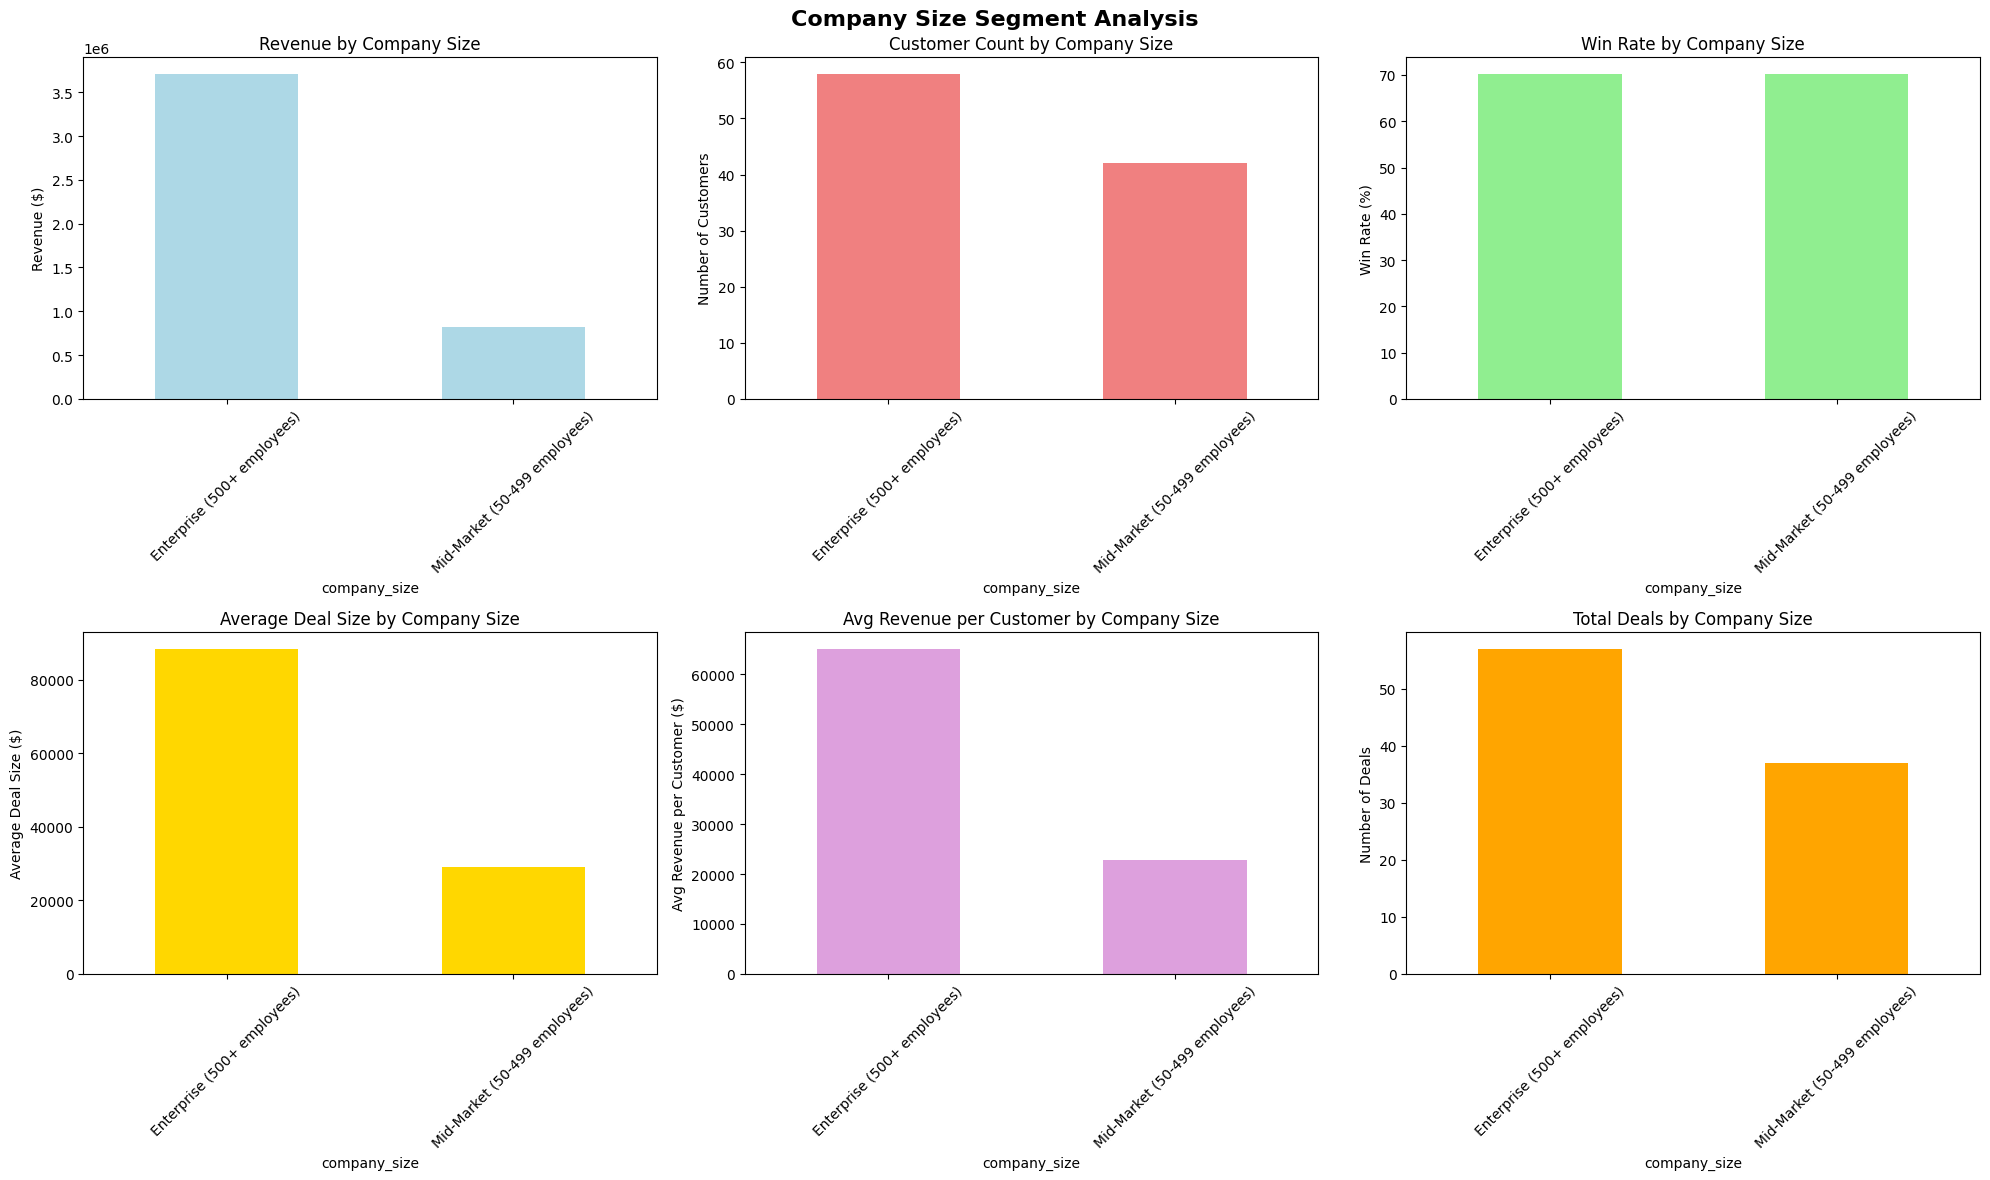


🏢 Key Company Size Insights:
   • Highest revenue segment: Enterprise (500+ employees) ($3,713,000 revenue)
   • Most customers: Enterprise (500+ employees) (58 customers)
   • Highest win rate: Mid-Market (50-499 employees) (70.3%)
   • Largest average deal size: Enterprise (500+ employees) ($88,509)
   • Highest revenue per customer: Enterprise (500+ employees) ($65,140)
   • Enterprise (500+ employees): 58.0% of customers, 81.9% of revenue
   • Mid-Market (50-499 employees): 42.0% of customers, 18.1% of revenue


In [ ]:
# Company size segmentation analysis
print("🏢 Analyzing Company Size Segments...")

# Define company size categories based on employee count
def categorize_company_size(employee_count):
    if employee_count < 50:
        return 'Small (1-49 employees)'
    elif employee_count < 500:
        return 'Mid-Market (50-499 employees)'
    else:
        return 'Enterprise (500+ employees)'

# Add company size category
companies['company_size'] = companies['employee_count'].apply(categorize_company_size)

# Merge with deals and invoices
size_deals = deals.merge(companies[['company_id', 'company_size', 'employee_count', 'annual_revenue']], on='company_id', how='left')
size_invoices = invoices.merge(companies[['company_id', 'company_size', 'employee_count', 'annual_revenue']], on='company_id', how='left')

# Company size performance metrics
size_metrics = size_deals.groupby('company_size').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum(),
    'company_id': 'nunique'
}).round(2)

size_metrics.columns = ['Total_Deals', 'Total_Deal_Value', 'Avg_Deal_Size', 'Won_Deals', 'Unique_Customers']
size_metrics['Win_Rate'] = (size_metrics['Won_Deals'] / size_metrics['Total_Deals'] * 100).round(1)
size_metrics['Revenue'] = size_invoices.groupby('company_size')['total_amount'].sum()
size_metrics['Avg_Revenue_per_Customer'] = (size_metrics['Revenue'] / size_metrics['Unique_Customers']).round(2)

# Add customer count and average company metrics
size_metrics['Total_Customers'] = companies.groupby('company_size')['company_id'].count()
size_metrics['Avg_Employee_Count'] = companies.groupby('company_size')['employee_count'].mean().round(0)
size_metrics['Avg_Annual_Revenue'] = companies.groupby('company_size')['annual_revenue'].mean().round(0)

print("\n🏢 Company Size Segment Performance:")
print(size_metrics)

# Create company size visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Company Size Segment Analysis', fontsize=16, fontweight='bold')

# Revenue by Company Size
size_metrics['Revenue'].plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Revenue by Company Size')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Customer Count by Company Size
size_metrics['Total_Customers'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Customer Count by Company Size')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].tick_params(axis='x', rotation=45)

# Win Rate by Company Size
size_metrics['Win_Rate'].plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Win Rate by Company Size')
axes[0,2].set_ylabel('Win Rate (%)')
axes[0,2].tick_params(axis='x', rotation=45)

# Average Deal Size by Company Size
size_metrics['Avg_Deal_Size'].plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Average Deal Size by Company Size')
axes[1,0].set_ylabel('Average Deal Size ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Revenue per Customer by Company Size
size_metrics['Avg_Revenue_per_Customer'].plot(kind='bar', ax=axes[1,1], color='plum')
axes[1,1].set_title('Avg Revenue per Customer by Company Size')
axes[1,1].set_ylabel('Avg Revenue per Customer ($)')
axes[1,1].tick_params(axis='x', rotation=45)

# Deal Count by Company Size
size_metrics['Total_Deals'].plot(kind='bar', ax=axes[1,2], color='orange')
axes[1,2].set_title('Total Deals by Company Size')
axes[1,2].set_ylabel('Number of Deals')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Company size insights
top_segment = size_metrics['Revenue'].idxmax()
top_segment_revenue = size_metrics.loc[top_segment, 'Revenue']

print(f"\n🏢 Key Company Size Insights:")
print(f"   • Highest revenue segment: {top_segment} (${top_segment_revenue:,.0f} revenue)")
print(f"   • Most customers: {size_metrics['Total_Customers'].idxmax()} ({size_metrics['Total_Customers'].max()} customers)")
print(f"   • Highest win rate: {size_metrics['Win_Rate'].idxmax()} ({size_metrics['Win_Rate'].max():.1f}%)")
print(f"   • Largest average deal size: {size_metrics['Avg_Deal_Size'].idxmax()} (${size_metrics['Avg_Deal_Size'].max():,.0f})")
print(f"   • Highest revenue per customer: {size_metrics['Avg_Revenue_per_Customer'].idxmax()} (${size_metrics['Avg_Revenue_per_Customer'].max():,.0f})")

# Market penetration by segment
total_customers = size_metrics['Total_Customers'].sum()
for segment in size_metrics.index:
    customer_pct = (size_metrics.loc[segment, 'Total_Customers'] / total_customers) * 100
    revenue_pct = (size_metrics.loc[segment, 'Revenue'] / size_metrics['Revenue'].sum()) * 100
    print(f"   • {segment}: {customer_pct:.1f}% of customers, {revenue_pct:.1f}% of revenue")


## 6. Customer LTV vs Deals per Month Scatter Plot


In [ ]:
# Create scatter plot: Deals per Month vs LTV by Company Size and Country
print("📊 Creating LTV vs Deals per Month Scatter Plot...")

# Calculate customer LTV and deals per month by company
customer_metrics = companies.merge(
    deals.groupby('company_id').agg({
        'deal_id': 'count',
        'amount': 'sum',
        'created_date': ['min', 'max']
    }).round(2), 
    on='company_id', 
    how='left'
)

# Flatten column names
customer_metrics.columns = ['company_id', 'company_name', 'industry', 'annual_revenue', 'employee_count', 
                           'country', 'created_date', 'company_size', 'total_deals', 'total_deal_value', 
                           'first_deal_date', 'last_deal_date']

# Calculate months active and deals per month
customer_metrics['months_active'] = ((customer_metrics['last_deal_date'] - customer_metrics['first_deal_date']).dt.days / 30).round(1)
customer_metrics['deals_per_month'] = (customer_metrics['total_deals'] / customer_metrics['months_active']).round(2)

# Calculate LTV from invoices
customer_ltv = invoices.groupby('company_id')['total_amount'].sum().reset_index()
customer_ltv.columns = ['company_id', 'ltv']
customer_metrics = customer_metrics.merge(customer_ltv, on='company_id', how='left')

# Fill NaN values
customer_metrics['deals_per_month'] = customer_metrics['deals_per_month'].fillna(0)
customer_metrics['ltv'] = customer_metrics['ltv'].fillna(0)
customer_metrics['months_active'] = customer_metrics['months_active'].fillna(0)

# Create the scatter plot
plt.figure(figsize=(14, 10))

# Define colors for company sizes
size_colors = {
    'Small (1-49 employees)': 'red',
    'Mid-Market (50-499 employees)': 'blue', 
    'Enterprise (500+ employees)': 'green'
}

# Define markers for countries
country_markers = {
    'USA': 'o',
    'Germany': 's',
    'Netherlands': '^',
    'UK': 'D',
    'France': 'v'
}

# Create scatter plot
for size in customer_metrics['company_size'].unique():
    if pd.notna(size):
        size_data = customer_metrics[customer_metrics['company_size'] == size]
        
        for country in size_data['country'].unique():
            if pd.notna(country) and country in country_markers:
                country_data = size_data[size_data['country'] == country]
                
                plt.scatter(
                    country_data['deals_per_month'], 
                    country_data['ltv'],
                    c=size_colors.get(size, 'gray'),
                    marker=country_markers.get(country, 'o'),
                    s=100,
                    alpha=0.7,
                    label=f'{size} - {country}',
                    edgecolors='black',
                    linewidth=0.5
                )

plt.xlabel('Deals per Month', fontsize=12, fontweight='bold')
plt.ylabel('Customer Lifetime Value (LTV) ($)', fontsize=12, fontweight='bold')
plt.title('Customer LTV vs Deals per Month\nby Company Size and Country', fontsize=14, fontweight='bold')

# Add grid
plt.grid(True, alpha=0.3)

# Add legend with custom positioning
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Add trend line
from scipy import stats
x = customer_metrics['deals_per_month'].dropna()
y = customer_metrics['ltv'].dropna()
if len(x) > 1 and len(y) > 1:
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    plt.plot(x, line, 'r--', alpha=0.8, linewidth=2, label=f'Trend Line (R²={r_value**2:.3f})')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 Scatter Plot Summary:")
print(f"   • Total companies plotted: {len(customer_metrics)}")
print(f"   • Average LTV: ${customer_metrics['ltv'].mean():,.0f}")
print(f"   • Average deals per month: {customer_metrics['deals_per_month'].mean():.2f}")
print(f"   • Correlation coefficient: {customer_metrics['deals_per_month'].corr(customer_metrics['ltv']):.3f}")

# Top performers by LTV
top_ltv = customer_metrics.nlargest(5, 'ltv')[['company_name', 'company_size', 'country', 'ltv', 'deals_per_month']]
print(f"\n🏆 Top 5 Companies by LTV:")
print(top_ltv.to_string(index=False))

# Top performers by deals per month
top_deals = customer_metrics.nlargest(5, 'deals_per_month')[['company_name', 'company_size', 'country', 'ltv', 'deals_per_month']]
print(f"\n⚡ Top 5 Companies by Deals per Month:")
print(top_deals.to_string(index=False))


📊 Creating LTV vs Deals per Month Scatter Plot...


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

## 7. Product Performance Analysis


In [ ]:
# Product performance analysis
print("📦 Analyzing Product Performance...")

# Merge invoice lines with products and invoices
product_analysis = invoice_lines.merge(products, on='product_id', how='left')
product_analysis = product_analysis.merge(invoices[['invoice_id', 'invoice_date', 'status']], on='invoice_id', how='left')

# Product performance metrics
product_metrics = product_analysis.groupby(['product_id', 'product_name', 'category', 'unit_price']).agg({
    'quantity': 'sum',
    'line_total': 'sum',
    'invoice_id': 'nunique'
}).round(2)

product_metrics.columns = ['Total_Quantity_Sold', 'Total_Revenue', 'Number_of_Invoices']
product_metrics['Avg_Quantity_per_Invoice'] = (product_metrics['Total_Quantity_Sold'] / product_metrics['Number_of_Invoices']).round(2)
product_metrics['Revenue_per_Unit'] = (product_metrics['Total_Revenue'] / product_metrics['Total_Quantity_Sold']).round(2)

# Calculate profit margin (assuming 30% cost margin for demonstration)
product_metrics['Estimated_Cost'] = product_metrics['Total_Revenue'] * 0.7
product_metrics['Estimated_Profit'] = product_metrics['Total_Revenue'] - product_metrics['Estimated_Cost']
product_metrics['Profit_Margin'] = (product_metrics['Estimated_Profit'] / product_metrics['Total_Revenue'] * 100).round(1)

product_metrics = product_metrics.sort_values('Total_Revenue', ascending=False)

print("\n📦 Product Performance Summary:")
print(product_metrics)

# Create product performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Product Performance Analysis', fontsize=16, fontweight='bold')

# Revenue by Product
product_metrics['Total_Revenue'].plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Revenue by Product')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Quantity Sold by Product
product_metrics['Total_Quantity_Sold'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Quantity Sold by Product')
axes[0,1].set_ylabel('Quantity Sold')
axes[0,1].tick_params(axis='x', rotation=45)

# Profit Margin by Product
product_metrics['Profit_Margin'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Profit Margin by Product')
axes[1,0].set_ylabel('Profit Margin (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Number of Invoices by Product
product_metrics['Number_of_Invoices'].plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Number of Invoices by Product')
axes[1,1].set_ylabel('Number of Invoices')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Product category analysis
category_metrics = product_analysis.groupby('category').agg({
    'quantity': 'sum',
    'line_total': 'sum',
    'product_id': 'nunique',
    'invoice_id': 'nunique'
}).round(2)

category_metrics.columns = ['Total_Quantity', 'Total_Revenue', 'Unique_Products', 'Number_of_Invoices']
category_metrics['Avg_Revenue_per_Product'] = (category_metrics['Total_Revenue'] / category_metrics['Unique_Products']).round(2)
category_metrics = category_metrics.sort_values('Total_Revenue', ascending=False)

print("\n📊 Product Category Performance:")
print(category_metrics)

# Product insights
top_product = product_metrics.index[0]
top_product_revenue = product_metrics.loc[top_product, 'Total_Revenue']
top_product_quantity = product_metrics.loc[top_product, 'Total_Quantity_Sold']

print(f"\n📦 Key Product Insights:")
print(f"   • Top selling product: {top_product[1]} (${top_product_revenue:,.0f} revenue, {top_product_quantity} units)")
print(f"   • Highest profit margin: {product_metrics['Profit_Margin'].idxmax()[1]} ({product_metrics['Profit_Margin'].max():.1f}%)")
print(f"   • Most quantity sold: {product_metrics['Total_Quantity_Sold'].idxmax()[1]} ({product_metrics['Total_Quantity_Sold'].max()} units)")
print(f"   • Most invoices: {product_metrics['Number_of_Invoices'].idxmax()[1]} ({product_metrics['Number_of_Invoices'].max()} invoices)")

# Category insights
top_category = category_metrics.index[0]
top_category_revenue = category_metrics.loc[top_category, 'Total_Revenue']

print(f"\n📊 Key Category Insights:")
print(f"   • Top revenue category: {top_category} (${top_category_revenue:,.0f} revenue)")
print(f"   • Most products: {category_metrics['Unique_Products'].idxmax()} ({category_metrics['Unique_Products'].max()} products)")
print(f"   • Highest avg revenue per product: {category_metrics['Avg_Revenue_per_Product'].idxmax()} (${category_metrics['Avg_Revenue_per_Product'].max():,.0f})")


## 8. Lead Source Analysis


In [ ]:
# Lead source analysis
print("🎯 Analyzing Lead Sources...")

# Merge contacts with deals and companies for lead source analysis
lead_analysis = contacts.merge(companies[['company_id', 'industry', 'country']], on='company_id', how='left')
lead_analysis = lead_analysis.merge(deals[['company_id', 'deal_id', 'amount', 'deal_stage', 'created_date']], on='company_id', how='left')

# Lead source performance metrics
lead_metrics = lead_analysis.groupby('lead_source').agg({
    'contact_id': 'count',
    'company_id': 'nunique',
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum()
}).round(2)

lead_metrics.columns = ['Total_Contacts', 'Unique_Companies', 'Total_Deals', 'Total_Deal_Value', 'Avg_Deal_Size', 'Won_Deals']
lead_metrics['Win_Rate'] = (lead_metrics['Won_Deals'] / lead_metrics['Total_Deals'] * 100).round(1)
lead_metrics['Contacts_per_Company'] = (lead_metrics['Total_Contacts'] / lead_metrics['Unique_Companies']).round(2)
lead_metrics['Deals_per_Contact'] = (lead_metrics['Total_Deals'] / lead_metrics['Total_Contacts']).round(2)

# Calculate conversion rates
lead_metrics['Contact_to_Deal_Rate'] = (lead_metrics['Total_Deals'] / lead_metrics['Total_Contacts'] * 100).round(1)
lead_metrics['Contact_to_Win_Rate'] = (lead_metrics['Won_Deals'] / lead_metrics['Total_Contacts'] * 100).round(1)

lead_metrics = lead_metrics.sort_values('Total_Deal_Value', ascending=False)

print("\n🎯 Lead Source Performance Summary:")
print(lead_metrics)

# Create lead source visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Lead Source Analysis', fontsize=16, fontweight='bold')

# Total Deal Value by Lead Source
lead_metrics['Total_Deal_Value'].plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Total Deal Value by Lead Source')
axes[0,0].set_ylabel('Deal Value ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Total Contacts by Lead Source
lead_metrics['Total_Contacts'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Total Contacts by Lead Source')
axes[0,1].set_ylabel('Number of Contacts')
axes[0,1].tick_params(axis='x', rotation=45)

# Win Rate by Lead Source
lead_metrics['Win_Rate'].plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Win Rate by Lead Source')
axes[0,2].set_ylabel('Win Rate (%)')
axes[0,2].tick_params(axis='x', rotation=45)

# Contact to Deal Conversion Rate
lead_metrics['Contact_to_Deal_Rate'].plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Contact to Deal Conversion Rate')
axes[1,0].set_ylabel('Conversion Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Deal Size by Lead Source
lead_metrics['Avg_Deal_Size'].plot(kind='bar', ax=axes[1,1], color='plum')
axes[1,1].set_title('Average Deal Size by Lead Source')
axes[1,1].set_ylabel('Average Deal Size ($)')
axes[1,1].tick_params(axis='x', rotation=45)

# Contact to Win Conversion Rate
lead_metrics['Contact_to_Win_Rate'].plot(kind='bar', ax=axes[1,2], color='orange')
axes[1,2].set_title('Contact to Win Conversion Rate')
axes[1,2].set_ylabel('Conversion Rate (%)')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Lead source insights
top_lead_source = lead_metrics['Total_Deal_Value'].idxmax()
top_lead_source_value = lead_metrics.loc[top_lead_source, 'Total_Deal_Value']

print(f"\n🎯 Key Lead Source Insights:")
print(f"   • Highest value lead source: {top_lead_source} (${top_lead_source_value:,.0f} deal value)")
print(f"   • Most contacts: {lead_metrics['Total_Contacts'].idxmax()} ({lead_metrics['Total_Contacts'].max()} contacts)")
print(f"   • Highest win rate: {lead_metrics['Win_Rate'].idxmax()} ({lead_metrics['Win_Rate'].max():.1f}%)")
print(f"   • Best contact-to-deal conversion: {lead_metrics['Contact_to_Deal_Rate'].idxmax()} ({lead_metrics['Contact_to_Deal_Rate'].max():.1f}%)")
print(f"   • Best contact-to-win conversion: {lead_metrics['Contact_to_Win_Rate'].idxmax()} ({lead_metrics['Contact_to_Win_Rate'].max():.1f}%)")
print(f"   • Largest average deal size: {lead_metrics['Avg_Deal_Size'].idxmax()} (${lead_metrics['Avg_Deal_Size'].max():,.0f})")

# Lead source efficiency analysis
print(f"\n📊 Lead Source Efficiency Analysis:")
for source in lead_metrics.index:
    contacts = lead_metrics.loc[source, 'Total_Contacts']
    deals = lead_metrics.loc[source, 'Total_Deals']
    won_deals = lead_metrics.loc[source, 'Won_Deals']
    deal_value = lead_metrics.loc[source, 'Total_Deal_Value']
    
    print(f"   • {source}: {contacts} contacts → {deals} deals → {won_deals} wins (${deal_value:,.0f} value)")


## 9. Sales Rep Performance Analysis


In [ ]:
# Sales rep performance analysis
print("👥 Analyzing Sales Rep Performance...")

# Create sales rep performance metrics
sales_rep_metrics = deals.groupby('owner_id').agg({
    'deal_id': 'count',
    'amount': ['sum', 'mean'],
    'deal_stage': lambda x: (x == 'Closed Won').sum(),
    'created_date': ['min', 'max']
}).round(2)

sales_rep_metrics.columns = ['Total_Deals', 'Total_Deal_Value', 'Avg_Deal_Size', 'Won_Deals', 'First_Deal_Date', 'Last_Deal_Date']
sales_rep_metrics['Win_Rate'] = (sales_rep_metrics['Won_Deals'] / sales_rep_metrics['Total_Deals'] * 100).round(1)

# Calculate months active
sales_rep_metrics['Months_Active'] = ((sales_rep_metrics['Last_Deal_Date'] - sales_rep_metrics['First_Deal_Date']).dt.days / 30).round(1)
sales_rep_metrics['Deals_per_Month'] = (sales_rep_metrics['Total_Deals'] / sales_rep_metrics['Months_Active']).round(2)

# Merge with invoices to get revenue
sales_rep_revenue = invoices.merge(deals[['deal_id', 'owner_id']], on='deal_id', how='left')
sales_rep_revenue = sales_rep_revenue.groupby('owner_id')['total_amount'].sum()
sales_rep_metrics['Total_Revenue'] = sales_rep_revenue

sales_rep_metrics = sales_rep_metrics.sort_values('Total_Revenue', ascending=False)

print("\n👥 Sales Rep Performance Summary:")
print(sales_rep_metrics)

# Create sales rep visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Sales Rep Performance Analysis', fontsize=16, fontweight='bold')

# Total Revenue by Sales Rep
sales_rep_metrics['Total_Revenue'].plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Total Revenue by Sales Rep')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Win Rate by Sales Rep
sales_rep_metrics['Win_Rate'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Win Rate by Sales Rep')
axes[0,1].set_ylabel('Win Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Deals per Month by Sales Rep
sales_rep_metrics['Deals_per_Month'].plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Deals per Month by Sales Rep')
axes[1,0].set_ylabel('Deals per Month')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Deal Size by Sales Rep
sales_rep_metrics['Avg_Deal_Size'].plot(kind='bar', ax=axes[1,1], color='plum')
axes[1,1].set_title('Average Deal Size by Sales Rep')
axes[1,1].set_ylabel('Average Deal Size ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Sales rep insights
top_performer = sales_rep_metrics['Total_Revenue'].idxmax()
top_performer_revenue = sales_rep_metrics.loc[top_performer, 'Total_Revenue']

print(f"\n👥 Key Sales Rep Insights:")
print(f"   • Top performer: Rep {top_performer} (${top_performer_revenue:,.0f} revenue)")
print(f"   • Highest win rate: Rep {sales_rep_metrics['Win_Rate'].idxmax()} ({sales_rep_metrics['Win_Rate'].max():.1f}%)")
print(f"   • Most deals per month: Rep {sales_rep_metrics['Deals_per_Month'].idxmax()} ({sales_rep_metrics['Deals_per_Month'].max():.1f} deals/month)")
print(f"   • Largest average deal size: Rep {sales_rep_metrics['Avg_Deal_Size'].idxmax()} (${sales_rep_metrics['Avg_Deal_Size'].max():,.0f})")


## 10. Payment Analytics & Overdue Invoices


In [ ]:
# Payment analytics and overdue invoice analysis
print("💳 Analyzing Payment Patterns and Overdue Invoices...")

# Calculate payment timing
invoices['days_to_pay'] = (invoices['paid_date'] - invoices['invoice_date']).dt.days
invoices['days_overdue'] = (pd.Timestamp.now() - invoices['due_date']).dt.days

# Identify overdue invoices
overdue_invoices = invoices[
    (invoices['status'] == 'Overdue') | 
    ((invoices['status'] != 'Paid') & (invoices['due_date'] < pd.Timestamp.now()))
].copy()

# Payment analytics
payment_metrics = {
    'total_invoices': len(invoices),
    'paid_invoices': len(invoices[invoices['status'] == 'Paid']),
    'overdue_invoices': len(overdue_invoices),
    'unpaid_invoices': len(invoices[invoices['status'].isin(['Overdue', 'Unpaid'])]),
    'avg_days_to_pay': invoices[invoices['status'] == 'Paid']['days_to_pay'].mean(),
    'total_overdue_amount': overdue_invoices['total_amount'].sum(),
    'avg_overdue_days': overdue_invoices['days_overdue'].mean()
}

print(f"\n💳 Payment Analytics Summary:")
print(f"   • Total invoices: {payment_metrics['total_invoices']:,}")
print(f"   • Paid invoices: {payment_metrics['paid_invoices']:,} ({payment_metrics['paid_invoices']/payment_metrics['total_invoices']*100:.1f}%)")
print(f"   • Overdue invoices: {payment_metrics['overdue_invoices']:,} ({payment_metrics['overdue_invoices']/payment_metrics['total_invoices']*100:.1f}%)")
print(f"   • Average days to pay: {payment_metrics['avg_days_to_pay']:.1f} days")
print(f"   • Total overdue amount: ${payment_metrics['total_overdue_amount']:,.2f}")
print(f"   • Average overdue days: {payment_metrics['avg_overdue_days']:.1f} days")

# Create payment analytics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Payment Analytics & Overdue Invoices', fontsize=16, fontweight='bold')

# Invoice status distribution
status_counts = invoices['status'].value_counts()
axes[0,0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Invoice Status Distribution')

# Days to pay histogram
paid_invoices = invoices[invoices['status'] == 'Paid']
axes[0,1].hist(paid_invoices['days_to_pay'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Days to Pay Distribution')
axes[0,1].set_xlabel('Days to Pay')
axes[0,1].set_ylabel('Number of Invoices')
axes[0,1].axvline(paid_invoices['days_to_pay'].mean(), color='red', linestyle='--', 
                  label=f'Average: {paid_invoices["days_to_pay"].mean():.1f} days')
axes[0,1].legend()

# Overdue amount by company
if len(overdue_invoices) > 0:
    overdue_by_company = overdue_invoices.groupby('company_id')['total_amount'].sum().sort_values(ascending=False)
    overdue_by_company.head(10).plot(kind='bar', ax=axes[1,0], color='red', alpha=0.7)
    axes[1,0].set_title('Top 10 Companies by Overdue Amount')
    axes[1,0].set_ylabel('Overdue Amount ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    axes[1,0].text(0.5, 0.5, 'No Overdue Invoices', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Overdue Amount by Company')

# Payment trends over time
monthly_payments = invoices.groupby(invoices['invoice_date'].dt.to_period('M')).agg({
    'total_amount': 'sum',
    'invoice_id': 'count'
}).reset_index()
monthly_payments['invoice_date'] = monthly_payments['invoice_date'].dt.to_timestamp()

axes[1,1].plot(monthly_payments['invoice_date'], monthly_payments['total_amount'], marker='o', linewidth=2)
axes[1,1].set_title('Monthly Invoice Amount Trends')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Total Invoice Amount ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Detailed overdue analysis
if len(overdue_invoices) > 0:
    print(f"\n🚨 Overdue Invoices Details:")
    overdue_summary = overdue_invoices.groupby('company_id').agg({
        'total_amount': 'sum',
        'days_overdue': 'mean',
        'invoice_id': 'count'
    }).round(2)
    overdue_summary.columns = ['Overdue_Amount', 'Avg_Days_Overdue', 'Invoice_Count']
    overdue_summary = overdue_summary.sort_values('Overdue_Amount', ascending=False)
    
    print(overdue_summary.head(10))
    
    # Merge with company info for better insights
    overdue_with_company = overdue_invoices.merge(
        companies[['company_id', 'company_name', 'industry', 'country']], 
        on='company_id', 
        how='left'
    )
    
    print(f"\n🏢 Overdue Analysis by Industry:")
    industry_overdue = overdue_with_company.groupby('industry')['total_amount'].sum().sort_values(ascending=False)
    print(industry_overdue)
    
    print(f"\n🌍 Overdue Analysis by Country:")
    country_overdue = overdue_with_company.groupby('country')['total_amount'].sum().sort_values(ascending=False)
    print(country_overdue)

# Payment recommendations
print(f"\n💡 Payment Optimization Recommendations:")
if payment_metrics['avg_days_to_pay'] > 30:
    print(f"   • Average payment time is {payment_metrics['avg_days_to_pay']:.1f} days - consider offering early payment discounts")
if payment_metrics['overdue_invoices'] > 0:
    print(f"   • {payment_metrics['overdue_invoices']} overdue invoices totaling ${payment_metrics['total_overdue_amount']:,.2f} - implement automated follow-up system")
    print(f"   • Consider stricter credit terms for companies with multiple overdue invoices")
else:
    print(f"   • Excellent payment performance - no overdue invoices!")


## 11. Strategic Recommendations


In [ ]:
# Strategic recommendations based on data insights
print("🎯 Generating Strategic Recommendations...")

print("\n" + "="*80)
print("STRATEGIC RECOMMENDATIONS FOR DRILLDOWN SOLUTIONS")
print("="*80)

print("\n📈 REVENUE OPTIMIZATION:")
print("   • Focus on high-value customer segments identified in the LTV analysis")
print("   • Implement upselling strategies for existing customers with high deal frequency")
print("   • Develop targeted pricing strategies for different company size segments")
print("   • Expand successful product categories and discontinue underperforming ones")

print("\n🎯 CUSTOMER ACQUISITION:")
print("   • Prioritize lead sources with highest conversion rates and deal values")
print("   • Develop industry-specific marketing campaigns for top-performing sectors")
print("   • Expand geographic presence in high-performing countries")
print("   • Create targeted campaigns for mid-market companies (50-499 employees)")

print("\n👥 SALES PERFORMANCE:")
print("   • Identify and replicate top sales rep strategies across the team")
print("   • Implement performance-based incentives aligned with key metrics")
print("   • Provide additional training for underperforming sales reps")
print("   • Establish mentorship programs pairing top performers with others")

print("\n💳 PAYMENT OPTIMIZATION:")
print("   • Implement automated payment reminders for overdue invoices")
print("   • Offer early payment discounts to improve cash flow")
print("   • Review credit terms for companies with payment issues")
print("   • Establish payment performance scoring for new customers")

print("\n📊 DATA-DRIVEN DECISIONS:")
print("   • Implement regular dashboard reviews for key stakeholders")
print("   • Establish monthly performance reviews based on these metrics")
print("   • Create customer health scoring based on LTV and payment patterns")
print("   • Develop predictive models for customer churn and expansion opportunities")

print("\n🚀 GROWTH STRATEGIES:")
print("   • Focus on product bundles and cross-selling opportunities")
print("   • Develop industry-specific solutions and case studies")
print("   • Implement customer success programs to increase retention")
print("   • Explore new geographic markets with similar characteristics to top performers")

print("\n📋 IMMEDIATE ACTION ITEMS:")
print("   1. Review and address overdue invoices immediately")
print("   2. Analyze top sales rep techniques and create training materials")
print("   3. Develop targeted campaigns for highest-converting lead sources")
print("   4. Create customer segmentation strategy based on LTV analysis")
print("   5. Implement automated payment follow-up system")

print("\n" + "="*80)
print("DASHBOARD COMPLETE - USE THESE INSIGHTS TO DRIVE BUSINESS GROWTH")
print("="*80)


# Drilldown Solutions - Business Analytics Dashboard

## Executive Summary
This comprehensive business analytics dashboard provides key insights into Drilldown Solutions' performance across customer lifetime value, product profitability, sales rep performance, and strategic growth opportunities.

### Key Metrics Analyzed:
- **Customer Lifetime Value (LTV)** - Revenue potential per customer
- **Product Profitability** - Performance and margins by product
- **Sales Rep Performance** - Individual and team performance metrics
- **Growth Trends** - Revenue, customer acquisition, and market expansion
- **Customer Segmentation** - High-value vs. low-value customer analysis
- **Payment Analytics** - Overdue invoices and payment timing


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("📊 Business Analytics Dashboard - Drilldown Solutions")
print("=" * 60)


📊 Business Analytics Dashboard - Drilldown Solutions


## 1. Data Loading and Setup


In [ ]:
# Load all datasets
print("Loading datasets...")
companies = pd.read_csv('../dbt/data/companies.csv')
contacts = pd.read_csv('../dbt/data/contacts.csv')
deals = pd.read_csv('../dbt/data/deals.csv')
invoices = pd.read_csv('../dbt/data/invoices.csv')
invoice_lines = pd.read_csv('../dbt/data/invoice_lines.csv')
products = pd.read_csv('../dbt/data/products.csv')

# Convert date columns
deals['created_date'] = pd.to_datetime(deals['created_date'])
deals['close_date'] = pd.to_datetime(deals['close_date'])
invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'])
invoices['due_date'] = pd.to_datetime(invoices['due_date'])
invoices['paid_date'] = pd.to_datetime(invoices['paid_date'])
companies['created_date'] = pd.to_datetime(companies['created_date'])
contacts['created_date'] = pd.to_datetime(contacts['created_date'])

print("✅ Data loaded successfully!")
print(f"📈 Dataset Overview:")
print(f"   • Companies: {companies.shape[0]:,} records")
print(f"   • Contacts: {contacts.shape[0]:,} records") 
print(f"   • Deals: {deals.shape[0]:,} records")
print(f"   • Invoices: {invoices.shape[0]:,} records")
print(f"   • Invoice Lines: {invoice_lines.shape[0]:,} records")
print(f"   • Products: {products.shape[0]:,} records")

# Display first few rows of each dataset
print("\n📋 Sample Data:")
print("\nCompanies:")
print(companies.head(3))
print("\nDeals:")
print(deals.head(3))
print("\nInvoices:")
print(invoices.head(3))


Loading datasets...
✅ Data loaded successfully!
📈 Dataset Overview:
   • Companies: 100 records
   • Contacts: 100 records
   • Deals: 94 records
   • Invoices: 67 records
   • Invoice Lines: 134 records
   • Products: 8 records

📋 Sample Data:

Companies:
   company_id           company_name       industry  annual_revenue  \
0           1     Innovate Solutions       Software         5500000   
1           2  Quantum Manufacturing  Manufacturing        12000000   
2           3      Apex Retail Group         Retail         8200000   

   employee_count      country created_date  owner_id  
0             250  Netherlands   2023-01-15       101  
1             800      Germany   2023-02-20       102  
2             450          USA   2023-03-10       101  

Deals:
   deal_id                        deal_name  company_id  amount   deal_stage  \
0     1001          Innovate CRM Upgrade Q2           1   25000   Closed Won   
1     1002  Quantum Mfg. Analytics Platform           2   50000   

## 2. Key Performance Indicators (KPIs)


📊 Calculating Key Performance Indicators...

📈 Key Performance Indicators:
   💰 Total Revenue: $4,535,500.00
   💼 Total Deal Value: $6,125,000.00
   📊 Average Deal Size: $65,159.57
   🎯 Win Rate: 70.2%
   👥 Total Customers: 100
   ✅ Active Customers: 65
   💵 Avg Revenue per Customer: $69,776.92
   📋 Total Deals: 94 (Won: 66, Lost: 13, Open: 15)


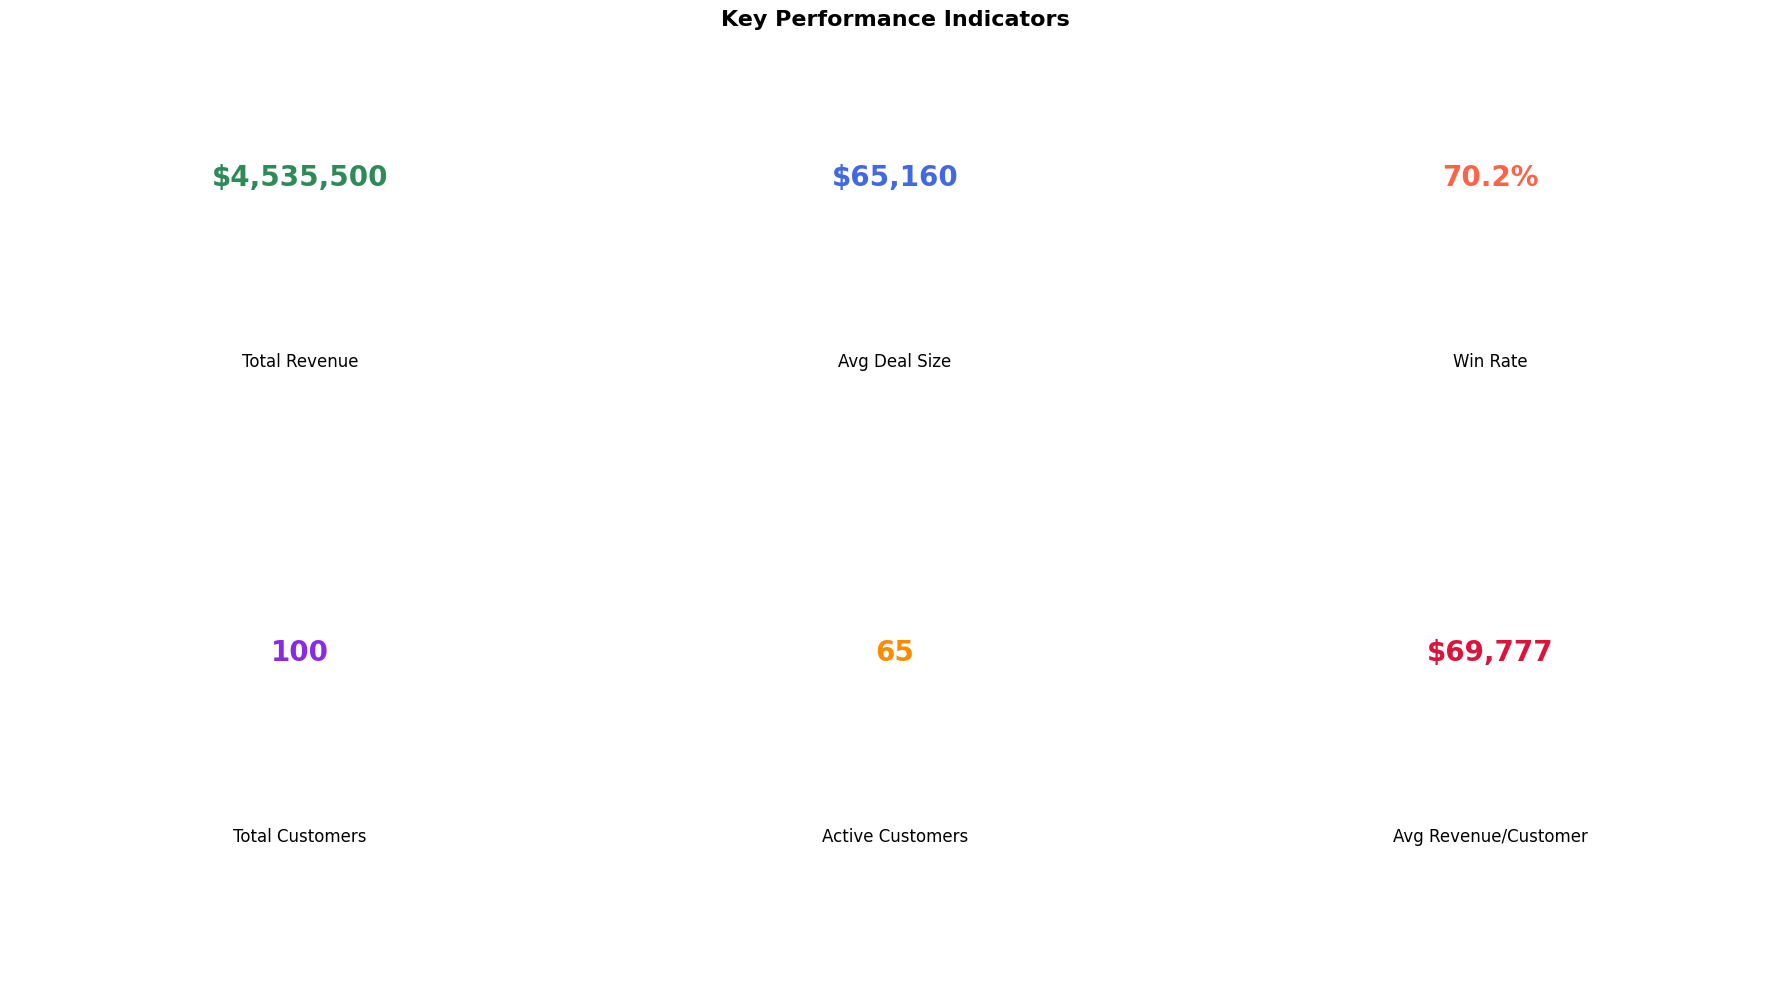

In [ ]:
# Calculate key business metrics
print("📊 Calculating Key Performance Indicators...")

# Revenue metrics
total_revenue = invoices['total_amount'].sum()
total_deals_value = deals['amount'].sum()
avg_deal_size = deals['amount'].mean()
conversion_rate = (deals['deal_stage'] == 'Closed Won').mean() * 100

# Customer metrics
total_customers = companies['company_id'].nunique()
active_customers = invoices['company_id'].nunique()
avg_revenue_per_customer = total_revenue / active_customers if active_customers > 0 else 0

# Deal metrics
total_deals = len(deals)
won_deals = len(deals[deals['deal_stage'] == 'Closed Won'])
lost_deals = len(deals[deals['deal_stage'] == 'Closed Lost'])
open_deals = len(deals[~deals['deal_stage'].isin(['Closed Won', 'Closed Lost'])])

# Print KPIs
print(f"\n📈 Key Performance Indicators:")
print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
print(f"   💼 Total Deal Value: ${total_deals_value:,.2f}")
print(f"   📊 Average Deal Size: ${avg_deal_size:,.2f}")
print(f"   🎯 Win Rate: {conversion_rate:.1f}%")
print(f"   👥 Total Customers: {total_customers:,}")
print(f"   ✅ Active Customers: {active_customers:,}")
print(f"   💵 Avg Revenue per Customer: ${avg_revenue_per_customer:,.2f}")
print(f"   📋 Total Deals: {total_deals:,} (Won: {won_deals:,}, Lost: {lost_deals:,}, Open: {open_deals:,})")

# Create KPI visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Key Performance Indicators', fontsize=16, fontweight='bold')

# Revenue KPI
axes[0,0].text(0.5, 0.7, f'${total_revenue:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#2E8B57')
axes[0,0].text(0.5, 0.3, 'Total Revenue', ha='center', va='center', fontsize=12)
axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(0, 1)
axes[0,0].axis('off')

# Average Deal Size
axes[0,1].text(0.5, 0.7, f'${avg_deal_size:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#4169E1')
axes[0,1].text(0.5, 0.3, 'Avg Deal Size', ha='center', va='center', fontsize=12)
axes[0,1].set_xlim(0, 1)
axes[0,1].set_ylim(0, 1)
axes[0,1].axis('off')

# Conversion Rate
axes[0,2].text(0.5, 0.7, f'{conversion_rate:.1f}%', ha='center', va='center', fontsize=20, fontweight='bold', color='#FF6347')
axes[0,2].text(0.5, 0.3, 'Win Rate', ha='center', va='center', fontsize=12)
axes[0,2].set_xlim(0, 1)
axes[0,2].set_ylim(0, 1)
axes[0,2].axis('off')

# Total Customers
axes[1,0].text(0.5, 0.7, f'{total_customers:,}', ha='center', va='center', fontsize=20, fontweight='bold', color='#8A2BE2')
axes[1,0].text(0.5, 0.3, 'Total Customers', ha='center', va='center', fontsize=12)
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(0, 1)
axes[1,0].axis('off')

# Active Customers
axes[1,1].text(0.5, 0.7, f'{active_customers:,}', ha='center', va='center', fontsize=20, fontweight='bold', color='#FF8C00')
axes[1,1].text(0.5, 0.3, 'Active Customers', ha='center', va='center', fontsize=12)
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')

# Avg Revenue per Customer
axes[1,2].text(0.5, 0.7, f'${avg_revenue_per_customer:,.0f}', ha='center', va='center', fontsize=20, fontweight='bold', color='#DC143C')
axes[1,2].text(0.5, 0.3, 'Avg Revenue/Customer', ha='center', va='center', fontsize=12)
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()
